# Introduction

Over the course of the last 15 to 20 years, statistics and probability have fundamentally changed the world of professional sports. This statistical 'revolution' is romanticized in the movie "Moneyball," based on Michael Lewis' book of the same name. In the film, set in 2002, the General Manager of the MLB Oakland Athletics, Billy Beane (played by Brad Pitt) teams up with Peter Brand, a fictious Yale economics graduate major that is based on the real life assistant GM at the time, Paul DePodesta (played by Jonah Hill) to radically alter how the Oakland A's assess player value. In order to compete with MLB teams that have much larger player payrolls, Beane and DePodesta had to find players that were undervalued by the standard collective wisdom of baseballs' scouts, managers, and coaches. As such, they had to apply a new method of evaluating player value.  
  
They defied commonly followed baseball stats, and the intuition of their scouts, and started to use sabermetrics. Roughly defined, sabermetrics is an empirical analysis of in-game activity. Through advanced statistical analysis, certain indicators (on-base percentage, slugging percentage, etc.) were determined to be better predictors of offensive success than the 'standard' stats (batting avg, stolen bases, etc.). Focusing on these stats, Beane and his staff were able to acquire players that were atypical and undervalued. It helped the Oakland A's to set a 20-game win streak, and successfully compete with franchises with significantly larger payrolls (Yankees, Red Sox, etc.) than themselves. Since then, using sabermetrics has become a pillar of valuing players in Major League Baseball.
    
Beane and DePondesta effectively changed the landscape of evaluating professional baseball players. A very similiar change is occuring in the National Hockey League, albeit late to the table in comparision to the other major sports, it has gained a lot of traction in the last few years. Especially during the 2014-15 season, when the NHL partnered with SAP to create an enhanced statistical package that matched up with launch of a new website featuring advanced analytics. This also coincided with several prominent NHL franchises adding data analytics positions to their front office including Kyle Dubas (Toronto Maple Leafs), Tyler Dellow (Edmonton Oilers), and Sunny Mehta (New Jersey Devils). Since then, it has really taken off. 

## NHL Advanced Stats

Parity is at all time high in the NHL. When the trade deadline rolls around in late February, many teams still fancy themselves in the hunt for the Stanley Cup. To add to that effect, ever since the LA Kings won the Cup in 2012 as an 8 seed (and went 16-4 no less), many teams believe the whole mantra of "you just have to make it to the playoffs, and then anything can happen."

This inevitably leads to a glut of 'buyers' (teams looking to pickup players to increase their chances of winning) at the trade deadline, but not nearly as many 'sellers' (teams that want to get of rid of players for future draft picks or young prospects). This, in conjunction with the salary cap that I'll discuss later, means finding undervalued players is a quintessential way to try to gain an edge come playoff time.

My hope is that I am able to find the best statistics to understand player value vs how much that player makes.

Which leads me to my data science question: Can you build a model to predict NHL player's salaries? What are the best predictors of how much a player will make? 

If I can find undervalued players, that would ideally help a general manager make decisions on who to try to acquire.

For closing thoughts / next steps:
NHL deputy commissioner Bill Daly confirmed to theScore that a full rollout of player and puck tracking is penciled in to debut during the 2019-20 season.

# Imports

In [258]:
# Run all imports - some used, some not.
import pandas as pd
import numpy as np
import requests
import time
import regex as re
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from math import sqrt
from scipy.stats import stats, iqr
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, accuracy_score

%matplotlib inline

# Data Collection

## NHL Salary Cap

Introduced after the full-season lockout of 04-05, the NHL currently has a salary cap in place. The main purposes of this salary cap is to curtail player salary growth to a reasonably manageable level, but also allow smaller-market teams to compete with larger-market teams. This cap is referred to as a 'hard' salary cap, meaning that each team can only spend up to that cap amount on a team of (at least) 24 players, up to a maximum of 50 players. 
  
As one of my metrics for understanding player value will be value added vs cap hit, I'll be using the NHL salary cap to gauge how much each player is making as a percentage of their teams' total cap.  

As I was only able to find player salary information going back to the 2011-2012 season, and the cap changes a variable amount every year, I'll be manually entering the salary cap for each year. And in cases where I might need it in varying formats, I'll be entering it once as a full year-to-year label (2011-2012), and once as a single year with the starting year representing the whole season (so, 2011-2012 would equal just 2011). There's probably a better way to do it than this, but it's moot as writing these both out doesn't take much time at all.

In [2]:
salary_cap_y2y = {"2011-2012":64300000,
                  "2012-2013":70200000,
                  "2013-2014":64300000,
                  "2014-2015":69000000,
                  "2015-2016":71400000,
                  "2016-2017":73000000,
                  "2017-2018":75000000}

salary_cap_year = {"2011":64300000,
                  "2012":70200000,
                  "2013":64300000,
                  "2014":69000000,
                  "2015":71400000,
                  "2016":73000000,
                  "2017":75000000}

## Scraper Code - Part I - Player Performance Data

**Note: After further research, I ended up finding a better, more detailed site that included extra data points.** This site (http://www.corsica.hockey/) allows its user to extract the information into .csv, rendering this loop, and the subsquent data pulled, redundant. However, since I put a great deal of effort into getting this loop to run properly, I'm going to leave it here to show my work. The code was original run, and it worked, but leaving it off of subsquent runs for timeliness. 

I have to pull player salary from a different source than player performance data, so there will be two seperate data pulls and therefore loops.

These next dozen cells or so are going to be aimed at testing out functionality before creating a loop.

### Relevant URLs that I'll be pulling from.

First page:

https://www.hockey-reference.com/play-index/ppbp_finder.cgi?c2stat=&c4stat=&c2comp=&order_by_asc=&game_location=&c1comp=&year_min=2008&request=1&franch_id=&birth_country=&match=single&year_max=2018&c3comp=&report=ppbp&season_end=-1&c3stat=&order_by=player&season_start=1&c1val=&c3val=&c2val=&handed=&rookie=N&pos=S&describe_only=&c1stat=&situation_id=ev&c4val=&age_min=0&age_max=99&c4comp=&offset=0

Second page:

https://www.hockey-reference.com/play-index/ppbp_finder.cgi?c2stat=&c4stat=&c2comp=&order_by_asc=&game_location=&c1comp=&year_min=2008&request=1&franch_id=&birth_country=&match=single&year_max=2018&c3comp=&report=ppbp&season_end=-1&c3stat=&order_by=player&season_start=1&c1val=&c3val=&c2val=&handed=&rookie=N&pos=S&describe_only=&c1stat=&situation_id=ev&c4val=&age_min=0&age_max=99&c4comp=&offset=100

Notes:
- There's 100 players on each page, and the URL actually iterates by 100.
- I ran through all possible pages to figure out where the iteration would have to end. Looks like that's 9684 rows, so I'll stop at 9600 for the URL, as it should include all players up until 9700.

In [ ]:
# So first off, I'm going to write code that pulls just one page, and make sure that works.
# Once that's done, I'm going to put in the pull for the second page, to make sure I understand how to combine the two
# Then I'll write a loop based off of those two pulls to get the remaining data
# First page URL from above:
url = 'https://www.hockey-reference.com/play-index/ppbp_finder.cgi?c2stat=&c4stat=&c2comp=&order_by_asc=&game_location=&c1comp=&year_min=2008&request=1&franch_id=&birth_country=&match=single&year_max=2018&c3comp=&report=ppbp&season_end=-1&c3stat=&order_by=player&season_start=1&c1val=&c3val=&c2val=&handed=&rookie=N&pos=S&describe_only=&c1stat=&situation_id=ev&c4val=&age_min=0&age_max=99&c4comp=&offset=0'

# Second page:
url2 = 'https://www.hockey-reference.com/play-index/ppbp_finder.cgi?c2stat=&c4stat=&c2comp=&order_by_asc=&game_location=&c1comp=&year_min=2008&request=1&franch_id=&birth_country=&match=single&year_max=2018&c3comp=&report=ppbp&season_end=-1&c3stat=&order_by=player&season_start=1&c1val=&c3val=&c2val=&handed=&rookie=N&pos=S&describe_only=&c1stat=&situation_id=ev&c4val=&age_min=0&age_max=99&c4comp=&offset=100'

### Pull request, status code check, and transform into BeautifulSoup

In [ ]:
# Get request
res = requests.get(url)
# res2 = requests.get(url2)

In [ ]:
# Confirm we got a successful response code
res.status_code

In [ ]:
# Setup my soup object to parse out the data
soup = BeautifulSoup(res.content, 'lxml')
# soup2 = BeautifulSoup(res2.content, 'lxml')

In [ ]:
# Take a brief look to make sure it pulled correctly
soup.text

In [ ]:
# This find_all is exploratory, to understand how it's pulling, and how I can break it down further
soup.find_all('td', {'class':'left'})

In [ ]:
# These are the individual scrapes, which I'll aggregate to loop and pull
# Creating them and printing them to make sure they work
player_name = soup.find_all('td', {'class':'left', 'data-stat':'player'})
pos = soup.find_all('td', {'class':'center', 'data-stat':'pos'})
team_id = soup.find_all('td', {'class':'left', 'data-stat':'team_id'})
season = soup.find_all('td', {'class':'left', 'data-stat':'season'})
games_played = soup.find_all('td', {'class':'right', 'data-stat':'games_played'})
goals = soup.find_all('td', {'class':'right', 'data-stat':'goals'})
assists = soup.find_all('td', {'class':'right', 'data-stat':'assists'})
points = soup.find_all('td', {'class':'right', 'data-stat':'points'})
corsi_for = soup.find_all('td', {'class':'right', 'data-stat':'corsi_for'})
corsi_against = soup.find_all('td', {'class':'right', 'data-stat':'corsi_against'})
corsi_pct = soup.find_all('td', {'class':'right', 'data-stat':'corsi_pct'})
corsi_rel_pct = soup.find_all('td', {'class':'right', 'data-stat':'corsi_rel_pct'})
corsi_per_60 = soup.find_all('td', {'class':'right', 'data-stat':'corsi_per_60'})
corsi_rel_per_60 = soup.find_all('td', {'class':'right', 'data-stat':'corsi_rel_per_60'})
fenwick_for = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_for'})
fenwick_against = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_against'})
fenwick_pct = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_pct'})
fenwick_rel_pct = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_rel_pct'})
on_ice_shot_pct = soup.find_all('td', {'class':'right', 'data-stat':'on_ice_shot_pct'})
on_ice_sv_pct = soup.find_all('td', {'class':'right', 'data-stat':'on_ice_sv_pct'})
pdo = soup.find_all('td', {'class':'right', 'data-stat':'pdo'})
zs_offense_pct = soup.find_all('td', {'class':'right', 'data-stat':'zs_offense_pct'})
zs_defense_pct = soup.find_all('td', {'class':'right', 'data-stat':'zs_defense_pct'})
toi_pbp_avg = soup.find_all('td', {'class':'right', 'data-stat':'toi_pbp_avg'})
faceoff_wins = soup.find_all('td', {'class':'right', 'data-stat':'faceoff_wins'})
faceoff_losses = soup.find_all('td', {'class':'right', 'data-stat':'faceoff_losses'})
faceoff_percentage = soup.find_all('td', {'class':'center', 'data-stat':'faceoff_percentage'})
hits = soup.find_all('td', {'class':'right', 'data-stat':'hits'})
blocks = soup.find_all('td', {'class':'right', 'data-stat':'blocks'})
takeaways = soup.find_all('td', {'class':'right', 'data-stat':'takeaways'})
giveaways = soup.find_all('td', {'class':'right', 'data-stat':'giveaways'})

In [ ]:
# This cell to make sure each of my variables got pulled in correctly
# And that I can pull the data out as expected
# Print player 1's stats essentially
print(f'''
{player_name[0].text}
{pos[0].text}
{team_id[0].text}
{season[0].text}
{games_played[0].text}
{goals[0].text}
{assists[0].text}
{points[0].text}
{corsi_for[0].text}
{corsi_against[0].text}
{corsi_pct[0].text}
{corsi_rel_pct[0].text}
{corsi_per_60[0].text}
{corsi_rel_per_60[0].text}
{fenwick_for[0].text}
{fenwick_against[0].text}
{fenwick_pct[0].text}
{fenwick_rel_pct[0].text}
{on_ice_shot_pct[0].text}
{on_ice_sv_pct[0].text}
{pdo[0].text}
{zs_offense_pct[0].text}
{zs_defense_pct[0].text}
{toi_pbp_avg[0].text}
{faceoff_wins[0].text}
{faceoff_losses[0].text}
{faceoff_percentage[0].text}
{hits[0].text}
{blocks[0].text}
{takeaways[0].text}
{giveaways[0].text}
''')

In [ ]:
# This cell is to test putting together a dataframe from many lists
df_test_player1 = pd.DataFrame(
    {'player_name': player_name[0].text,
    'pos': pos[0].text, 
    'team_id': team_id[0].text, 
    'season': season[0].text, 
    'games_played': games_played[0].text, 
    'goals': goals[0].text, 
    'assists': assists[0].text, 
    'points': points[0].text, 
    'corsi_for': corsi_for[0].text, 
    'corsi_against': corsi_against[0].text, 
    'corsi_pct': corsi_pct[0].text, 
    'corsi_rel_pct': corsi_rel_pct[0].text, 
    'corsi_per_60': corsi_per_60[0].text, 
    'corsi_rel_per_60': corsi_rel_per_60[0].text, 
    'fenwick_for': fenwick_for[0].text, 
    'fenwick_against': fenwick_against[0].text, 
    'fenwick_pct': fenwick_pct[0].text, 
    'fenwick_rel_pct': fenwick_rel_pct[0].text, 
    'on_ice_shot_pct': on_ice_shot_pct[0].text, 
    'on_ice_sv_pct': on_ice_sv_pct[0].text, 
    'pdo': pdo[0].text, 
    'zs_offense_pct': zs_offense_pct[0].text, 
    'zs_defense_pct': zs_defense_pct[0].text, 
    'toi_pbp_avg': toi_pbp_avg[0].text, 
    'faceoff_wins': faceoff_wins[0].text, 
    'faceoff_losses': faceoff_losses[0].text, 
    'faceoff_percentage': faceoff_percentage[0].text, 
    'hits': hits[0].text, 
    'blocks': blocks[0].text, 
    'takeaways': takeaways[0].text, 
    'giveaways': giveaways[0].text}, index=[0])

In [ ]:
# Take a look at the df, compare it to the website to make sure everything lines up correctly
df_test_player1.T

In [ ]:
# Keeping this here for a visualization of how zip works,
# and how I might look through to aggregate my future lists together in a dataframe
for i, j in zip(player_name, season):
    print(i.text, j.text)

In [ ]:
goals = soup.find_all('td', {'class':'right', 'data-stat':'goals'})

In [ ]:
# Testing the url + next_get portion of the request pull
next_get = str(100)
url = 'https://www.hockey-reference.com/play-index/ppbp_finder.cgi?c2stat=&c4stat=&c2comp=&order_by_asc=&game_location=&c1comp=&year_min=2008&request=1&franch_id=&birth_country=&match=single&year_max=2018&c3comp=&report=ppbp&season_end=-1&c3stat=&order_by=player&season_start=1&c1val=&c3val=&c2val=&handed=&rookie=N&pos=S&describe_only=&c1stat=&situation_id=ev&c4val=&age_min=0&age_max=99&c4comp=&offset='

res = requests.get(url+next_get)

In [ ]:
# Testing creation of DF
df_puck = pd.DataFrame([], columns=['player_name', 'pos', 'team_id', 'season', 'games_played', 'goals', 'assists', 'points', 'corsi_for', 'corsi_against', 'corsi_pct', 'corsi_rel_pct', 'corsi_per_60', 'corsi_rel_per_60', 'fenwick_for', 'fenwick_against', 'fenwick_pct', 'fenwick_rel_pct', 'on_ice_shot_pct', 'on_ice_sv_pct', 'pdo', 'zs_offense_pct', 'zs_defense_pct', 'toi_pbp_avg', 'faceoff_wins', 'faceoff_losses', 'faceoff_percentage', 'hits', 'blocks', 'takeaways', 'giveaways'])

In [ ]:
# Testing appending
df_puck = df_puck.append(df_test_player1, )

In [ ]:
df_puck

In [ ]:
# Scraper loop
# Original URL
url = 'https://www.hockey-reference.com/play-index/ppbp_finder.cgi?c2stat=&c4stat=&c2comp=&order_by_asc=&game_location=&c1comp=&year_min=2008&request=1&franch_id=&birth_country=&match=single&year_max=2018&c3comp=&report=ppbp&season_end=-1&c3stat=&order_by=player&season_start=1&c1val=&c3val=&c2val=&handed=&rookie=N&pos=S&describe_only=&c1stat=&situation_id=ev&c4val=&age_min=0&age_max=99&c4comp=&offset='
df_puck = pd.DataFrame([], columns=['player_name', 'pos', 'team_id', 'season', 'games_played', 'goals', 'assists', 'points', 'corsi_for', 'corsi_against', 'corsi_pct', 'corsi_rel_pct', 'corsi_per_60', 'corsi_rel_per_60', 'fenwick_for', 'fenwick_against', 'fenwick_pct', 'fenwick_rel_pct', 'on_ice_shot_pct', 'on_ice_sv_pct', 'pdo', 'zs_offense_pct', 'zs_defense_pct', 'toi_pbp_avg', 'faceoff_wins', 'faceoff_losses', 'faceoff_percentage', 'hits', 'blocks', 'takeaways', 'giveaways'])

# See logic above for why I chose these numbers
for i in range(0, 9700, 100):
    
    # Create lists fresh on each loop
    player_name_list = []
    pos_list = []
    team_id_list = []
    season_list = []
    games_played_list = []
    goals_list = []
    assists_list = []
    points_list = []
    corsi_for_list = []
    corsi_against_list = []
    corsi_pct_list = []
    corsi_rel_pct_list = []
    corsi_per_60_list = []
    corsi_rel_per_60_list = []
    fenwick_for_list = []
    fenwick_against_list = []
    fenwick_pct_list = []
    fenwick_rel_pct_list = []
    on_ice_shot_pct_list = []
    on_ice_sv_pct_list = []
    pdo_list = []
    zs_offense_pct_list = []
    zs_defense_pct_list = []
    toi_pbp_avg_list = []
    faceoff_wins_list = []
    faceoff_losses_list = []
    faceoff_percentage_list = []
    hits_list = []
    blocks_list = []
    takeaways_list = []
    giveaways_list = []
    
    # Iteration to create end of URL
    next_get = str(i)
    
    # Request get
    res = requests.get(url+next_get)
    
    # Create into bs4 object
    soup = BeautifulSoup(res.content, 'lxml')
    
    # Breakdown soup via find_all into its various pieces
    player_name = soup.find_all('td', {'class':'left', 'data-stat':'player'})
    pos = soup.find_all('td', {'class':'center', 'data-stat':'pos'})
    team_id = soup.find_all('td', {'class':'left', 'data-stat':'team_id'})
    season = soup.find_all('td', {'class':'left', 'data-stat':'season'})
    games_played = soup.find_all('td', {'class':'right', 'data-stat':'games_played'})
    goals = soup.find_all('td', {'class':'right', 'data-stat':'goals'})
    assists = soup.find_all('td', {'class':'right', 'data-stat':'assists'})
    points = soup.find_all('td', {'class':'right', 'data-stat':'points'})
    corsi_for = soup.find_all('td', {'class':'right', 'data-stat':'corsi_for'})
    corsi_against = soup.find_all('td', {'class':'right', 'data-stat':'corsi_against'})
    corsi_pct = soup.find_all('td', {'class':'right', 'data-stat':'corsi_pct'})
    corsi_rel_pct = soup.find_all('td', {'class':'right', 'data-stat':'corsi_rel_pct'})
    corsi_per_60 = soup.find_all('td', {'class':'right', 'data-stat':'corsi_per_60'})
    corsi_rel_per_60 = soup.find_all('td', {'class':'right', 'data-stat':'corsi_rel_per_60'})
    fenwick_for = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_for'})
    fenwick_against = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_against'})
    fenwick_pct = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_pct'})
    fenwick_rel_pct = soup.find_all('td', {'class':'right', 'data-stat':'fenwick_rel_pct'})
    on_ice_shot_pct = soup.find_all('td', {'class':'right', 'data-stat':'on_ice_shot_pct'})
    on_ice_sv_pct = soup.find_all('td', {'class':'right', 'data-stat':'on_ice_sv_pct'})
    pdo = soup.find_all('td', {'class':'right', 'data-stat':'pdo'})
    zs_offense_pct = soup.find_all('td', {'class':'right', 'data-stat':'zs_offense_pct'})
    zs_defense_pct = soup.find_all('td', {'class':'right', 'data-stat':'zs_defense_pct'})
    toi_pbp_avg = soup.find_all('td', {'class':'right', 'data-stat':'toi_pbp_avg'})
    faceoff_wins = soup.find_all('td', {'class':'right', 'data-stat':'faceoff_wins'})
    faceoff_losses = soup.find_all('td', {'class':'right', 'data-stat':'faceoff_losses'})
    faceoff_percentage = soup.find_all('td', {'class':'center', 'data-stat':'faceoff_percentage'})
    hits = soup.find_all('td', {'class':'right', 'data-stat':'hits'})
    blocks = soup.find_all('td', {'class':'right', 'data-stat':'blocks'})
    takeaways = soup.find_all('td', {'class':'right', 'data-stat':'takeaways'})
    giveaways = soup.find_all('td', {'class':'right', 'data-stat':'giveaways'})
    
    # Add the various soup objects into a new dataframe
    for a in range(0, len(player_name), 1):
        if a == 0:
            df_append = pd.DataFrame(
            {'player_name': player_name[a].text,
            'pos': pos[a].text, 
            'team_id': team_id[a].text, 
            'season': season[a].text, 
            'games_played': games_played[a].text, 
            'goals': goals[a].text, 
            'assists': assists[a].text, 
            'points': points[a].text, 
            'corsi_for': corsi_for[a].text, 
            'corsi_against': corsi_against[a].text, 
            'corsi_pct': corsi_pct[a].text, 
            'corsi_rel_pct': corsi_rel_pct[a].text, 
            'corsi_per_60': corsi_per_60[a].text, 
            'corsi_rel_per_60': corsi_rel_per_60[a].text, 
            'fenwick_for': fenwick_for[a].text, 
            'fenwick_against': fenwick_against[a].text, 
            'fenwick_pct': fenwick_pct[a].text, 
            'fenwick_rel_pct': fenwick_rel_pct[a].text, 
            'on_ice_shot_pct': on_ice_shot_pct[a].text, 
            'on_ice_sv_pct': on_ice_sv_pct[a].text, 
            'pdo': pdo[a].text, 
            'zs_offense_pct': zs_offense_pct[a].text, 
            'zs_defense_pct': zs_defense_pct[a].text, 
            'toi_pbp_avg': toi_pbp_avg[a].text, 
            'faceoff_wins': faceoff_wins[a].text, 
            'faceoff_losses': faceoff_losses[a].text, 
            'faceoff_percentage': faceoff_percentage[a].text, 
            'hits': hits[a].text, 
            'blocks': blocks[a].text, 
            'takeaways': takeaways[a].text, 
            'giveaways': giveaways[a].text}, index=[i])
        else:
            df_append = df_append.append(
            {'player_name': player_name[a].text,
            'pos': pos[a].text, 
            'team_id': team_id[a].text, 
            'season': season[a].text, 
            'games_played': games_played[a].text, 
            'goals': goals[a].text, 
            'assists': assists[a].text, 
            'points': points[a].text, 
            'corsi_for': corsi_for[a].text, 
            'corsi_against': corsi_against[a].text, 
            'corsi_pct': corsi_pct[a].text, 
            'corsi_rel_pct': corsi_rel_pct[a].text, 
            'corsi_per_60': corsi_per_60[a].text, 
            'corsi_rel_per_60': corsi_rel_per_60[a].text, 
            'fenwick_for': fenwick_for[a].text, 
            'fenwick_against': fenwick_against[a].text, 
            'fenwick_pct': fenwick_pct[a].text, 
            'fenwick_rel_pct': fenwick_rel_pct[a].text, 
            'on_ice_shot_pct': on_ice_shot_pct[a].text, 
            'on_ice_sv_pct': on_ice_sv_pct[a].text, 
            'pdo': pdo[a].text, 
            'zs_offense_pct': zs_offense_pct[a].text, 
            'zs_defense_pct': zs_defense_pct[a].text, 
            'toi_pbp_avg': toi_pbp_avg[a].text, 
            'faceoff_wins': faceoff_wins[a].text, 
            'faceoff_losses': faceoff_losses[a].text, 
            'faceoff_percentage': faceoff_percentage[a].text, 
            'hits': hits[a].text, 
            'blocks': blocks[a].text, 
            'takeaways': takeaways[a].text, 
            'giveaways': giveaways[a].text}, ignore_index = True)
    
    # Kept getting timeout errors, so added a sleep to offset
    time.sleep(3)
    
    df_puck = df_puck.append(df_append, ignore_index = True)
    df_puck.to_csv('hockey_data.csv', index = True)

In [ ]:
# This pulls out the first year (first_year-second_year) to simplify that data point
df_puck['year'] = df_puck['season'].apply(lambda x: int(x[:4]))

In [ ]:
df_puck.head()

## Scraper Code - Part II - Player Cap Hits

**Note: As the dollar sign is used in latex/markdown cells for creating formulas, I can't write it here, so all stated monetary values are in USD.**

An important distinction to make before diving in here: a player's salary can, and usually is, different then their actual cap hit. A player's cap hit is the average annual value over the entire length of their contract.  
  
  So for example, in 2007, Pittsburgh Penguins' captain Sidney Crosby signed a 12-year, 104.4 million dollar contract. The average annual value comes out to 8.7 million/year, which is how much his salary counts against the cap. However, the deal is not evenly structured throughout the contract to pay Sid the Kid 8.7 mil/yr. He was paid 12 mil/yr the first 3 years of the contract, but will only be paid 3 mil/yr the last 3 years of the contract. The years in between do not vary as much as either tail of the contract, but the point is that player yearly salary =/= their salary cap hit.  
  
As the cap hit is truly what matters for building NHL teams, and it actually helps 'normalize' player salaries across the board, that's the more important measurement I'll be using here.

Base URL pulling from: https://www.spotrac.com/nhl/rankings/cap-hit/  
Subsquent URLs look like this: https://www.spotrac.com/nhl/rankings/YEAR/cap-hit/  
Where YEAR = the year the season opened in.

These next dozen cells or so are going to be aimed at testing out functionality before creating a loop.

In [3]:
# Base URL
url_base_cap_hit = 'https://www.spotrac.com/nhl/rankings/cap-hit/'

In [4]:
# Generate request and BeautifulSoup object off of that
res = requests.get(url_base_cap_hit)
soup = BeautifulSoup(res.content, 'lxml')

In [5]:
# Take a look at this nastiness just to make sure it ran properly
soup.text

' \n\n\n\n\n\nNHL Salary Rankings | Spotrac\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    window._mNHandle = window._mNHandle || {};\n    window._mNHandle.queue = window._mNHandle.queue || [];\n    medianet_versionId = "3121199"; \n\n\n\n\n\n\n\n\n\n\nCookie Settings\n\n\n\nAccept Cookies\n\n\n\nClose\n\n\n\n \nWe use cookies to offer you a better browsing experience, analyse site traffic, and serve targeted ads. Read how we use cookies and how you can control them in our “Cookie Settings”. By using our site, you consent to our use of cookies.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nspotrac\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nNFL\n\nTeam Salary Caps\nPositional Spending\nContracts\nSalary Rankings\nFree Agents\n\n\nTrackers & Tools\n\n» Market Values\n» Fines/Suspensions\n» IR Tracker\n» Depth Charts Tracker\n» Draft Tracker\n» Options\n» College Tracker\n\n\nBest Values\nTransactions\n\n\n\n\nNBA\n\nTeam Cap Tracker\nPositional Payrolls\nContracts\nSalary Rankings\nFree Agent

In [8]:
# To pull out the player_name and cap_hit
player_name = soup.find_all('a', {'class':'team-name'})
cap_hit = soup.find_all('span', {'class':'info'})
# Used this for year at one point, decided to scrap it to generate within the below loop
for_year = soup.find_all('h2', {'style':'border-bottom:0px;margin-bottom:0px;padding-bottom:0px;'})

In [9]:
# Check to make sure pulled correctly
print(f'''
{player_name[9].text},
{cap_hit[9].text},
{for_year[0].text[:4]}
''')


Jamie Benn,
$9,500,000  ,
2018



In [10]:
# Test out the first pull to make sure I'm doing this correctly
test_url = "https://www.spotrac.com/nhl/rankings/2011/cap-hit/anaheim-ducks"
res = requests.get(test_url)
soup = BeautifulSoup(res.content, 'lxml')
player_name = soup.find_all('a', {'class':'team-name'})
cap_hit = soup.find_all('span', {'class':'info'})

In [11]:
# Test print
print(f'''
{player_name[0].text},
{cap_hit[0].text}
''')


Ryan Getzlaf,
$5,325,000  



- After further testing, it doesn't seem that above URL can pull more than 100 entries at a time.
- Furthermore, the page uses 'never-ending' scrolling, so the URL never changes once you get past the first 100 entries.
- I'm going to have to create a loop to loop through each year, and I'm going to do it by team name.
- Max amount of contracts an NHL team can have is 50, so this should hopefully work.
- As a result, I'll have to create a list with each team name in it.

**Note: The number of teams in this list does not equal the number of teams that have been in the NHL from 2011 to 2017. The Arizona Coyotes were named the Phoenix Coyotes up until 2014 (so they appear twice), and the Vegas Golden Knights are an expansion team that was added in 2017.**

In [12]:
teams = ['anaheim-ducks',
         'arizona-coyotes',
         'boston-bruins',
         'buffalo-sabres',
         'calgary-flames',
         'carolina-hurricanes',
         'chicago-blackhawks',
         'colorado-avalanche',
         'columbus-blue-jackets',
         'dallas-stars',
         'detroit-red-wings',
         'edmonton-oilers',
         'florida-panthers',
         'los-angeles-kings',
         'minnesota-wild',
         'montreal-canadiens',
         'nashville-predators',
         'new-jersey-devils',
         'new-york-islanders',
         'new-york-rangers',
         'ottawa-senators',
         'philadelphia-flyers',
         'phoenix-coyotes',
         'pittsburgh-penguins',
         'san-jose-sharks',
         'st-louis-blues',
         'tampa-bay-lightning',
         'toronto-maple-leafs',
         'vancouver-canucks',
         'vegas-golden-knights',
         'washington-capitals',
         'winnipeg-jets']

In [13]:
# Make sure this loop will work for all the teams
for team in teams:
    print("team_name:{}".format(team))

team_name:anaheim-ducks
team_name:arizona-coyotes
team_name:boston-bruins
team_name:buffalo-sabres
team_name:calgary-flames
team_name:carolina-hurricanes
team_name:chicago-blackhawks
team_name:colorado-avalanche
team_name:columbus-blue-jackets
team_name:dallas-stars
team_name:detroit-red-wings
team_name:edmonton-oilers
team_name:florida-panthers
team_name:los-angeles-kings
team_name:minnesota-wild
team_name:montreal-canadiens
team_name:nashville-predators
team_name:new-jersey-devils
team_name:new-york-islanders
team_name:new-york-rangers
team_name:ottawa-senators
team_name:philadelphia-flyers
team_name:phoenix-coyotes
team_name:pittsburgh-penguins
team_name:san-jose-sharks
team_name:st-louis-blues
team_name:tampa-bay-lightning
team_name:toronto-maple-leafs
team_name:vancouver-canucks
team_name:vegas-golden-knights
team_name:washington-capitals
team_name:winnipeg-jets


In [14]:
# For testing, and clearing out my data when I need to
df_cap = pd.DataFrame()

In [16]:
# Scraper for salary cap info
# Create empty dataframe
df_cap = pd.DataFrame()
# Begin loop from teams created earlier
for team in teams:
    # The website I'm pulling from only goes back to 2011 
    # And I'm not going to be using data from the still-very-young 2018-19 season, so range is 2011 to 2017
    for i in range(1,8):
        
        # Generate URL
        url_base_cap_hit = ("https://www.spotrac.com/nhl/rankings/201{}/cap-hit/{}".format(i, team))

        # Request get
        res = requests.get(url_base_cap_hit)

        # Create soup object
        soup = BeautifulSoup(res.content, 'lxml')

        # Pull out relevant information
        player_name = soup.find_all('a', {'class':'team-name'})
        cap_hit = soup.find_all('span', {'class':'info'})
        
        # Append new data to DF
        for a in range(0, len(player_name)):
            df_cap = df_cap.append({'player_name': player_name[a].text,
                                          'cap_hit': cap_hit[a].text,
                                          'team_name':team,
                                          'year':"201{}".format(i)}, ignore_index = True)

# I saved the CSV originally, but so much data cleaning occurs afterwards
# that I'd just prefer to resave after cleaning down the road
# df_cap.to_csv('cap_data_uncleaned.csv', index=True)

In [ ]:
# Previously saved
# df_cap.to_csv('./data/cap_data.csv', index=True)

In [ ]:
# For when I want to start fresh with my uncleaned data - leaving commented out for nwo
# df_cap = pd.read_csv('./data/cap_data_uncleaned.csv', index_col='Unnamed: 0')

In [ ]:
# Get rid of the extra index
# df_cap = df_cap.drop(labels='Unnamed: 0.1', axis=1)

In [17]:
# Checking that the shape makes sense
df_cap.shape

(6485, 4)

In [18]:
# I had an issue with my loop that was causing players to appear on the wrong team
# This is just to check using similarly named players
df_cap[df_cap['player_name'].str.contains('Rask') == True]

,cap_hit,player_name,team_name,year
382,"$1,250,000",Tuukka Rask,boston-bruins,2011
406,"$3,500,000",Tuukka Rask,boston-bruins,2012
427,"$7,000,000",Tuukka Rask,boston-bruins,2013
456,"$7,000,000",Tuukka Rask,boston-bruins,2014
479,"$7,000,000",Tuukka Rask,boston-bruins,2015
514,"$7,000,000",Tuukka Rask,boston-bruins,2016
550,"$7,000,000",Tuukka Rask,boston-bruins,2017
1124,"$763,333",Victor Rask,carolina-hurricanes,2014
1156,"$680,833",Victor Rask,carolina-hurricanes,2015
1170,"$4,000,000",Victor Rask,carolina-hurricanes,2016


In [19]:
# Check out the types
# cap_hit will need to be converted to a int
df_cap.dtypes

cap_hit        object
player_name    object
team_name      object
year           object
dtype: object

In [20]:
# I'll need to get rid of the dollar sign, the commas, and the blank spaces in the cap hit column
df_cap['cap_hit'] = df_cap['cap_hit'].map(lambda x: x.replace('$',''))
df_cap['cap_hit'] = df_cap['cap_hit'].map(lambda x: x.replace(',',''))
df_cap['cap_hit'] = df_cap['cap_hit'].map(lambda x: x.replace('  ',''))

In [21]:
df_cap['cap_hit'] = df_cap['cap_hit'].astype(int)

In [22]:
df_cap.dtypes

cap_hit         int64
player_name    object
team_name      object
year           object
dtype: object

In [23]:
# Need to convert year back to object for changing to season
df_cap['year'] = df_cap['year'].astype(object)

In [24]:
df_cap.dtypes

cap_hit         int64
player_name    object
team_name      object
year           object
dtype: object

In [25]:
# Confirming on the frontend that these values match
df_cap.head()

,cap_hit,player_name,team_name,year
0,5325000,Ryan Getzlaf,anaheim-ducks,2011
1,5325000,Corey Perry,anaheim-ducks,2011
2,5100000,Bobby Ryan,anaheim-ducks,2011
3,4500000,Jonas Hiller,anaheim-ducks,2011
4,4000000,Teemu Selanne,anaheim-ducks,2011


In [26]:
# Confirming on the frontend that these values match
df_cap.tail()

,cap_hit,player_name,team_name,year
6480,675000,Jamie Phillips,winnipeg-jets,2017
6481,650000,Joe Morrow,winnipeg-jets,2017
6482,650000,Michael Sgarbossa,winnipeg-jets,2017
6483,636666,Eric Comrie,winnipeg-jets,2017
6484,625000,Julian Melchiori,winnipeg-jets,2017


In [27]:
# pd.set_option('display.max_row', 100)
# df_cap

## Cleaning up the Cap Hit Data

This data will need cleaned up in a few different ways so that it can be merged with the main player performance data.

In [28]:
# For later usage
S2Y_converter = {"2011-2012":"2011",
                  "2012-2013":"2012",
                  "2013-2014":"2013",
                  "2014-2015":"2014",
                  "2015-2016":"2015",
                  "2016-2017":"2016",
                  "2017-2018":"2017"}

Y2S_converter = {"2011":"2011-2012",
                  "2012":"2012-2013",
                  "2013":"2013-2014",
                  "2014":"2014-2015",
                  "2015":"2015-2016",
                  "2016":"2016-2017",
                  "2017":"2017-2018"}

In [29]:
# Change the data and the label from year to Season
df_cap['year'] = df_cap['year'].map(lambda x: x.replace(x, Y2S_converter[x]))

In [30]:
# For merging the dataframes down the line
df_cap.rename(columns={'player_name':'Player', 'year':'Season'}, inplace=True)

In [31]:
# Fix any potential oddities in the name column, so the merges work better
df_cap['Player'] = df_cap['Player'].map(lambda x: x.title())

In [32]:
df_cap.head()

,cap_hit,Player,team_name,Season
0,5325000,Ryan Getzlaf,anaheim-ducks,2011-2012
1,5325000,Corey Perry,anaheim-ducks,2011-2012
2,5100000,Bobby Ryan,anaheim-ducks,2011-2012
3,4500000,Jonas Hiller,anaheim-ducks,2011-2012
4,4000000,Teemu Selanne,anaheim-ducks,2011-2012


In [33]:
# To be able to merge the data, I need to be able to match on name
# So this is to simplify common names to their most base form
# Lemmatization for names!
Name_simplifier = {'Thomas':'Tom', 
                   'Alexander':'Alex',
                   'Alexandre':'Alex',
                   'Alexey':'Alex',
                   'Alexei':'Alex',
                   'Christopher':'Chris',
                   'Christian':'Chris',
                   'Cameron':'Cam',
                   'Danny':'Dan',
                   'Daniel':'Dan',
                   'T.J.':'Tj',
                   'T J ':'Tj',
                   'T J':'Tj',
                   'Vaclav':'Vincent',
                   'Vinnie':'Vincent',
                   'Zachary':'Zach',
                   'Zac':'Zach',
                   'Zack':'Zach'}

In [34]:
Name_simplifier['Thomas']

'Tom'

In [35]:
list(Name_simplifier.keys())

['Thomas',
 'Alexander',
 'Alexandre',
 'Alexey',
 'Alexei',
 'Christopher',
 'Christian',
 'Cameron',
 'Danny',
 'Daniel',
 'T.J.',
 'T J ',
 'T J',
 'Vaclav',
 'Vinnie',
 'Zachary',
 'Zac',
 'Zack']

In [36]:
# Example of a player whose name will need changed
df_cap[df_cap['Player'] == 'Alexander Semin']

,cap_hit,Player,team_name,Season
1063,7000000,Alexander Semin,carolina-hurricanes,2012-2013
1087,7000000,Alexander Semin,carolina-hurricanes,2013-2014
1112,7000000,Alexander Semin,carolina-hurricanes,2014-2015
6074,6700000,Alexander Semin,washington-capitals,2011-2012


In [37]:
# I get by with a little help from my TAs
# This is to apply the name changes for merging on later
df_cap['Player'] = df_cap['Player'].map(
    lambda x: x.split(' ')[0].replace(x.split(' ')[0], Name_simplifier[x.split(' ')[0]]) + ' ' + x.split(' ')[1] 
    if x.split(' ')[0] in Name_simplifier.keys() else x)

In [38]:
# Check to make sure it worked
df_cap[df_cap['Player'].str.contains('Semin') == True]

,cap_hit,Player,team_name,Season
1063,7000000,Alex Semin,carolina-hurricanes,2012-2013
1087,7000000,Alex Semin,carolina-hurricanes,2013-2014
1112,7000000,Alex Semin,carolina-hurricanes,2014-2015
6074,6700000,Alex Semin,washington-capitals,2011-2012


In [ ]:
# df_cap.to_csv('./data/cap_data_cleaned.csv', index=True)

# Data Cleaning & Combining

## Part I - Combining player performance and cap hit

I'll be using the player performance data that I pulled from http://corsica.hockey/skater-stats/, team data from http://corsica.hockey/team-stats/, and the cap data I scrapped in Part II. This next section I'll work on cleaning the data up, and combining these three data sets. Before that however, I'd like to highlight a important distinction between the data I'm looking at.

## Explaining the different play situations

In an normal NHL game, teams usually play each other with 5 skaters on the ice (3 forwards + 2 defensemen) and a goalie. This is known as 'even strength' play. However, a team can be assessed a penalty, which is an infraction for breaking a rule. The penalized team is forced to play down a man for either 2, 4, or 5 minutes, depending on the severity of the penalty. By far the most common penalty is 2 minutes though. During the ensuing 5 on 4, known as being on the 'powerplay,' play opens up significantly, and generally the team that is up a man is able to control the puck better because they have more open ice to skate, and passing lanes to distribute the puck to teammates.  
  
The key takeaway is that the powerplay is a distinct type of gameplay, and is played in a different style than normal 5 on 5 hockey. Coaches mix up how they deploy players, and players play different positions than they would normally. For example, often coaches will play 4 forwards and 1 defensemen on the powerplay. 
  
I highlight this fact because I will be making a distinction between stats collected at even strength play versus those on the powerplay because of how different of a play style they both are. 

All that being said, I may stick with just one set of data over another for sake of streamlining the project. Studying subject-matter material may reveal something I don't understand about the data. If I do go that direction, it will certainly be a subject I explore further post-DSI.

In [39]:
%pwd

'/Users/tomkelly/Desktop/general_assembly/DSI-US-5/Capstone-Project'

In [40]:
# All game situations (even strength + powerplay)
df_all = pd.read_csv('./data/skaters_All_Data.csv')
# Just even strength
df_es = pd.read_csv('./data/skaters_ES_Data.csv')
# Team data
df_team = pd.read_csv('./data/team_stats.csv')

In [41]:
print(f'''
{df_all.shape},
{df_es.shape},
{df_team.shape}
''')


(4746, 44),
(4676, 44),
(211, 28)



In [42]:
df_all.head()

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,ixGF,ixGF/60,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC
0,5EBASTIAN.AHO,2017-2018,NYI,D/D/R,22,357.43,1,3,4,2,...,0.90,0.15,4.17,100.13,44.69,27.12,28.19,49.83,29.49,48.01
1,AARON.EKBLAD,2014-2015,FLA,D,81,1766.60,12,27,39,22,...,9.11,0.31,7.06,100.62,66.19,35.68,30.40,53.99,30.17,46.05
2,AARON.EKBLAD,2015-2016,FLA,D,78,1690.83,15,20,35,23,...,9.81,0.35,8.24,101.92,60.39,35.80,31.18,52.08,30.95,47.13
3,AARON.EKBLAD,2016-2017,FLA,D,68,1459.29,10,11,21,14,...,12.02,0.49,4.44,97.21,64.51,35.12,30.87,54.64,30.87,47.02
4,AARON.EKBLAD,2017-2018,FLA,D,82,1917.89,16,22,38,22,...,12.96,0.41,8.47,101.72,41.08,38.65,33.37,52.47,33.19,51.10


As a self-considered subject matter expert, I'm already aware that 'Sebastian Aho' is the only name that is used by two seperate NHL players. Furthermore, one of them has played only 22 NHL games total and is now in the minor leagues, where the other has played over 180 and counting and is a staple on his team (Carolina Hurricanes). As I'll be combining cap data on name, I'll need to remove this potential duplicate issue. And since the former Sebastian Aho has significantly less NHL games under his belt, I'm going to remove his data.

In [43]:
# Dropping the 'other' Sebastian Aho and resetting the index
df_all = df_all.drop(index=0, axis=0).reset_index(drop=True)
# df_es = df_es.drop(index=0, axis=0).reset_index(drop=True)

In [44]:
# Quick check to make sure it worked
df_all.head()

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,ixGF,ixGF/60,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC
0,AARON.EKBLAD,2014-2015,FLA,D,81,1766.60,12,27,39,22,...,9.11,0.31,7.06,100.62,66.19,35.68,30.40,53.99,30.17,46.05
1,AARON.EKBLAD,2015-2016,FLA,D,78,1690.83,15,20,35,23,...,9.81,0.35,8.24,101.92,60.39,35.80,31.18,52.08,30.95,47.13
2,AARON.EKBLAD,2016-2017,FLA,D,68,1459.29,10,11,21,14,...,12.02,0.49,4.44,97.21,64.51,35.12,30.87,54.64,30.87,47.02
3,AARON.EKBLAD,2017-2018,FLA,D,82,1917.89,16,22,38,22,...,12.96,0.41,8.47,101.72,41.08,38.65,33.37,52.47,33.19,51.10
4,AARON.JOHNSON,2011-2012,CBJ,D,56,924.40,3,13,16,9,...,3.01,0.20,4.76,98.13,41.93,27.55,27.78,47.36,30.73,51.72


In [45]:
# Looks like the player name needs cleaned up a bit
# Replace the period
df_all['Player'] = df_all['Player'].map(lambda x: x.replace('.', ' '))
# df_es['Player'] = df_es['Player'].map(lambda x: x.replace('.', ' '))

In [46]:
# Use .title() to match the casing in the other data set
df_all['Player'] = df_all['Player'].map(lambda x: x.title())
# df_es['Player'] = df_es['Player'].map(lambda x: x.title())

In [47]:
# Check to make sure these worked
df_all['Player'].head(10)

0      Aaron Ekblad
1      Aaron Ekblad
2      Aaron Ekblad
3      Aaron Ekblad
4     Aaron Johnson
5        Aaron Ness
6    Aaron Palushaj
7    Aaron Palushaj
8        Aaron Rome
9        Aaron Rome
Name: Player, dtype: object

In [48]:
# Taking a look at the teams to determine if I need to drop some data points
df_all['Team'].unique()

array(['FLA', 'CBJ', 'NYI', 'MTL', 'COL', 'VAN', 'DAL', 'VAN/WSH', 'WSH',
       'S.J', 'CHI/VAN', 'PIT/EDM', 'NYR', 'VAN/EDM', 'T.B',
       'T.B/PHI/CAR', 'PHI', 'N.J', 'N.J/ANA', 'EDM', 'WPG', 'BOS', 'BUF',
       'EDM/WPG', 'ARI', 'L.A', 'EDM/OTT', 'WPG/ARI', 'VAN/OTT', 'OTT',
       'CGY', 'CHI', 'NSH', 'N.J/CAR', 'N.J/WPG', 'DET', 'DET/TOR', 'PIT',
       'STL', 'CAR', 'BUF/VAN', 'COL/ARI', 'VGK', 'TOR', 'COL/MTL',
       'CAR/PHI', 'MTL/NSH', 'PHI/BOS', 'CAR/DET', 'CAR/L.A', 'COL/CBJ',
       'ANA', 'S.J/CHI', 'WPG/CHI', 'NYI/PHI', 'ARI/CHI', 'CBJ/ARI',
       'ANA/PIT', 'CHI/S.J', 'TOR/S.J', 'TOR/COL', 'T.B/CGY', 'CGY/NYI',
       'CGY/CBJ', 'NSH/MTL', 'NSH/N.J', 'N.J/PIT', 'MIN/MTL', 'EDM/MTL',
       'MTL/EDM/NYI', 'ARI/VAN', 'CHI/FLA', 'FLA/ANA', 'NSH/COL',
       'PHI/T.B', 'VGK/VAN', 'CGY/CHI', 'DET/NYR', 'DAL/S.J', 'DAL/PIT',
       'T.B/BOS', 'T.B/TOR', 'BUF/MTL', 'OTT/T.B', 'NYI/BOS', 'WSH/TOR',
       'MIN', 'ARI/PIT/NSH', 'STL/BUF', 'BUF/MIN', 'MIN/CGY', 'ARI/NYR',
  

In [49]:
df_all[df_all['Team'].str.contains('/') == True].shape

(422, 44)

So that's 422 data points out of roughly 4700 that are on a player traded mid-season. I'm going to drop these rows as it complicates the data and analysis. Players traded mid-season may perform drastically different team-to-team.

In [50]:
# There's probably a cleaner way to do this, but this works:
df_all.drop(index=df_all[df_all['Team'].str.contains('/') == True].index, axis=0, inplace=True)
# df_es.drop(index=df_es[df_es['Team'].str.contains('/') == True].index, axis=0, inplace=True)

In [51]:
# Check
df_all[df_all['Team'].str.contains('/') == True]

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,ixGF,ixGF/60,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC


In [52]:
# This is to apply the name changes on df_all
df_all['Player'] = df_all['Player'].map(
    lambda x: x.split(' ')[0].replace(x.split(' ')[0], Name_simplifier[x.split(' ')[0]]) + ' ' + x.split(' ')[1] 
    if x.split(' ')[0] in Name_simplifier.keys() else x)

In [53]:
# # This is to apply the name changes on df_es
# df_es['Player'] = df_es['Player'].map(
#     lambda x: x.split(' ')[0].replace(x.split(' ')[0], Name_simplifier[x.split(' ')[0]]) + ' ' + x.split(' ')[1] 
#     if x.split(' ')[0] in Name_simplifier.keys() else x)

In [54]:
# Check to make sure it worked
df_all[df_all['Player'].str.contains('Oshie') == True]

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,ixGF,ixGF/60,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC
4335,Tj Oshie,2011-2012,STL,R,80,1562.33,19,35,54,43,...,21.15,0.81,10.11,101.75,50.65,32.05,34.410000,54.64,33.100000,49.77
4336,Tj Oshie,2012-2013,STL,R,30,572.80,7,12,19,14,...,6.35,0.67,10.77,95.95,51.45,31.44,33.980000,54.21,32.480000,48.98
4337,Tj Oshie,2013-2014,STL,R,79,1499.74,21,38,59,47,...,18.70,0.75,13.82,102.91,56.08,31.14,35.100000,56.48,33.290000,49.32
4338,Tj Oshie,2014-2015,STL,R,72,1356.03,19,36,55,42,...,17.57,0.78,11.73,101.92,51.28,30.94,34.060000,54.23,32.190000,49.12
4339,Tj Oshie,2015-2016,WSH,R,80,1517.09,26,25,51,37,...,20.71,0.82,14.05,103.02,56.70,31.38,inf,56.27,inf,47.99
4340,Tj Oshie,2016-2017,WSH,R,68,1214.12,33,23,56,49,...,20.07,0.99,23.08,106.08,59.57,29.44,37.090000,55.64,32.770000,47.26
4341,Tj Oshie,2017-2018,WSH,R,74,1362.54,19,28,47,36,...,15.57,0.69,14.84,101.97,60.40,30.50,40.480000,53.99,32.610000,45.83


In [55]:
df_all_cap = pd.merge(df_all, df_cap, how='left', left_on=['Player','Season'], right_on=['Player','Season'])
# df_es_cap = pd.merge(df_es, df_cap, how='left', left_on=['Player','Season'], right_on=['Player','Season'])

In [56]:
df_all_cap.head(10)

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC,cap_hit,team_name
0,Aaron Ekblad,2014-2015,FLA,D,81,1766.60,12,27,39,22,...,7.06,100.62,66.19,35.68,30.40,53.99,30.17,46.05,1775000.0,florida-panthers
1,Aaron Ekblad,2015-2016,FLA,D,78,1690.83,15,20,35,23,...,8.24,101.92,60.39,35.80,31.18,52.08,30.95,47.13,925000.0,florida-panthers
2,Aaron Ekblad,2016-2017,FLA,D,68,1459.29,10,11,21,14,...,4.44,97.21,64.51,35.12,30.87,54.64,30.87,47.02,925000.0,florida-panthers
3,Aaron Ekblad,2017-2018,FLA,D,82,1917.89,16,22,38,22,...,8.47,101.72,41.08,38.65,33.37,52.47,33.19,51.10,7500000.0,florida-panthers
4,Aaron Johnson,2011-2012,CBJ,D,56,924.40,3,13,16,9,...,4.76,98.13,41.93,27.55,27.78,47.36,30.73,51.72,550000.0,columbus-blue-jackets
5,Aaron Ness,2013-2014,NYI,D,20,295.88,1,1,2,1,...,4.35,91.63,50.86,24.39,27.13,48.67,29.44,50.97,NaN,NaN
6,Aaron Palushaj,2011-2012,MTL,R,38,287.52,1,4,5,2,...,2.70,99.93,48.46,13.02,26.89,47.12,27.81,48.81,883333.0,montreal-canadiens
7,Aaron Palushaj,2012-2013,COL,R,25,282.90,1,7,8,4,...,3.57,98.16,51.35,18.97,30.06,51.16,28.91,47.74,NaN,NaN
8,Aaron Rome,2011-2012,VAN,D,43,654.73,4,5,9,6,...,9.52,97.68,44.78,25.04,27.64,51.91,29.20,50.27,750000.0,vancouver-canucks
9,Aaron Rome,2012-2013,DAL,D,27,414.03,0,5,5,3,...,0.00,99.17,37.82,25.68,27.55,46.18,30.56,53.46,1500000.0,dallas-stars


In [57]:
# Looks like I need to go back through my data and figure out why the merge didn't work as well I would have liked
df_all_cap.isnull().sum().sort_values(ascending=False)

team_name    293
cap_hit      293
P1/60          0
GA             0
GF             0
Rel CF%        0
CF%            0
C+/-           0
CA             0
CF             0
GS/60          0
GS             0
P/60           0
P1             0
P              0
A              0
G              0
TOI            0
GP             0
Position       0
Team           0
Season         0
G+/-           0
GF%            0
Rel GF%        0
xGF            0
CF% QoC        0
TOI% QoC       0
CF% QoT        0
TOI% QoT       0
TOI%           0
ZSR            0
PDO            0
iSh%           0
ixGF/60        0
ixGF           0
iCF/60         0
iCF            0
iP+/-          0
iPEND          0
iPENT          0
Rel xGF%       0
xGF%           0
xG+/-          0
xGA            0
Player         0
dtype: int64

In [58]:
df_all_cap[df_all_cap['cap_hit'].isnull() == True]

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC,cap_hit,team_name
5,Aaron Ness,2013-2014,NYI,D,20,295.88,1,1,2,1,...,4.35,91.63,50.86,24.39,27.130000,48.67,29.44,50.97,NaN,NaN
7,Aaron Palushaj,2012-2013,COL,R,25,282.90,1,7,8,4,...,3.57,98.16,51.35,18.97,30.060000,51.16,28.91,47.74,NaN,NaN
15,Adam Burish,2014-2015,S.J,R,20,222.90,1,2,3,3,...,4.55,95.52,23.60,18.53,28.480000,47.00,30.63,54.47,NaN,NaN
20,Adam Hall,2011-2012,T.B,R,57,676.36,2,5,7,6,...,3.17,94.60,21.33,19.80,32.740000,39.91,35.02,59.31,NaN,NaN
81,Alex Burmistrov,2017-2018,VAN,C,23,278.11,2,4,6,5,...,12.50,97.63,44.94,20.11,30.240000,48.29,29.90,50.30,NaN,NaN
108,Alex Marchenko,2014-2015,DET,D,13,200.42,1,1,2,1,...,14.29,99.21,61.32,25.72,27.130000,51.16,29.09,52.37,NaN,NaN
141,Alex Petrovic,2014-2015,FLA,D,33,536.57,0,2,2,0,...,0.00,98.10,51.70,26.87,27.550000,49.77,29.37,51.86,NaN,NaN
145,Alex Picard,2011-2012,PIT,D,17,223.42,0,3,3,2,...,0.00,99.81,67.19,22.20,26.910000,54.99,28.68,49.74,NaN,NaN
173,Alex Urbom,2013-2014,WSH,D,20,292.11,1,1,2,2,...,6.25,102.21,46.97,24.17,27.320000,44.30,30.75,53.91,NaN,NaN
193,Andre Burakovsky,2014-2015,WSH,L,53,684.81,9,13,22,15,...,13.85,103.13,67.20,21.72,31.440000,54.47,29.51,46.66,NaN,NaN


In [59]:
# Previously run when I was deciding to drop players that haven't played enough to 'qualify' for my model
# I ended up just rerunning the data from the website I pulled from to only account for players with above 200 minutes played
# df_all_cap[(df_all_cap['TOI'] > 150) & (df_all_cap['cap_hit'].isnull() == True)]

In [60]:
# Some players for some years I just simply don't have the data
df_cap[df_cap['Player'].str.contains('Hinostroza') == True]

,cap_hit,Player,team_name,Season
1381,717500,Vincent Hinostroza,chicago-blackhawks,2015-2016
1413,717500,Vincent Hinostroza,chicago-blackhawks,2016-2017
1449,717500,Vincent Hinostroza,chicago-blackhawks,2017-2018


In [61]:
# Confirming other missed records
df_all_cap[(df_all_cap['Player'].str.contains('Zach') == True) & (df_all_cap['cap_hit'].isnull() == True)]

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC,cap_hit,team_name
4319,Zach Boychuk,2014-2015,CAR,L,31,329.41,3,3,6,5,...,8.57,100.36,53.00,18.22,28.55,51.48,28.97,48.76,NaN,NaN
4320,Zach Hyman,2015-2016,TOR,C,16,250.97,4,2,6,6,...,10.81,98.09,62.35,25.94,31.08,50.51,30.87,52.24,NaN,NaN
4332,Zach Sill,2013-2014,PIT,C,20,215.88,0,0,0,0,...,0.00,94.55,30.68,18.09,28.14,42.48,32.00,57.14,NaN,NaN
4333,Zach Trotman,2014-2015,BOS,D,27,442.99,1,4,5,1,...,2.17,97.79,59.33,27.22,28.70,52.29,29.81,50.14,NaN,NaN
4337,Zach Kassian,2012-2013,VAN,R,39,525.73,7,4,11,9,...,14.29,100.52,51.84,22.35,31.68,56.59,29.24,45.69,NaN,NaN
4355,Zach Rinaldo,2015-2016,BOS,C,52,431.40,1,2,3,2,...,2.63,100.30,47.44,14.12,26.90,46.43,27.77,50.00,NaN,NaN


- I've spent a great deal of time trying to match up the player performance/cap data on player name and season.
- This in cludes really digging around in the data to determine why the two sets aren't matching.
- I was able to reduce the non-matchups from about 950 to 313. 
- I'm going to drop the rest of those without cap data as most of the remaining players I simply cannot find the data for anywhere online.
- Most of these players didn't play significant time for their respective team, so it shouldn't be as big of a deal.

In [62]:
# I'd say 4013 data points is still sufficient to do my analysis
df_all_cap.dropna(axis=0, how='any').shape
# df_es_cap.dropna(axis=0, how='any').shape

(4083, 46)

In [63]:
# Actual drop
df_all_cap.dropna(axis=0, how='any', inplace=True)
# df_es_cap.dropna(axis=0, how='any', inplace=True)

In [64]:
# Check
df_all_cap[df_all_cap['cap_hit'].isnull() == True]

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC,cap_hit,team_name


In [65]:
df_all_cap[df_all_cap['Team'] == 'VGK']

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC,cap_hit,team_name
172,Alex Tuch,2017-2018,VGK,R,78,1188.51,15,21,36,30,...,8.77,100.98,63.89,25.36,32.13,56.25,30.43,45.24,925000.0,vegas-golden-knights
446,Brad Hunt,2017-2018,VGK,D,45,748.69,3,14,17,10,...,3.85,101.07,64.20,27.86,29.63,56.98,29.08,45.29,650000.0,vegas-golden-knights
529,Brayden Mcnabb,2017-2018,VGK,D,76,1530.10,5,10,15,7,...,5.68,101.14,40.59,33.74,29.74,47.32,32.95,55.19,1700000.0,vegas-golden-knights
896,Cody Eakin,2017-2018,VGK,C,80,1162.48,11,16,27,18,...,10.38,97.84,46.07,24.21,30.64,49.58,31.21,53.04,3850000.0,vegas-golden-knights
932,Colin Miller,2017-2018,VGK,D,82,1585.16,10,30,40,28,...,5.65,98.98,66.42,32.00,29.85,52.29,30.27,47.38,1000000.0,vegas-golden-knights
1161,David Perron,2017-2018,VGK,L,70,1245.71,15,50,65,49,...,12.10,102.37,61.00,29.38,32.69,55.80,31.34,46.08,3750000.0,vegas-golden-knights
1247,Deryk Engelland,2017-2018,VGK,D,79,1600.25,5,18,23,18,...,4.63,100.24,38.63,33.85,29.27,49.03,32.32,55.24,1000000.0,vegas-golden-knights
1427,Erik Haula,2017-2018,VGK,L,76,1319.06,29,26,55,40,...,16.57,99.57,60.53,28.68,33.21,54.47,31.33,46.62,2750000.0,vegas-golden-knights
1694,James Neal,2017-2018,VGK,L,71,1217.25,25,18,43,36,...,12.44,99.93,62.62,28.31,33.15,55.55,31.09,45.41,5000000.0,vegas-golden-knights
2060,Jonathan Marchessault,2017-2018,VGK,C,77,1347.85,27,47,74,60,...,10.11,104.52,61.75,28.92,33.32,54.42,31.41,45.73,750000.0,vegas-golden-knights


In [66]:
# Save my work
df_all_cap.to_csv('./data/all_cap_semicleaned.csv')

In [67]:
df_all_cap.head()

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC,cap_hit,team_name
0,Aaron Ekblad,2014-2015,FLA,D,81,1766.60,12,27,39,22,...,7.06,100.62,66.19,35.68,30.40,53.99,30.17,46.05,1775000.0,florida-panthers
1,Aaron Ekblad,2015-2016,FLA,D,78,1690.83,15,20,35,23,...,8.24,101.92,60.39,35.80,31.18,52.08,30.95,47.13,925000.0,florida-panthers
2,Aaron Ekblad,2016-2017,FLA,D,68,1459.29,10,11,21,14,...,4.44,97.21,64.51,35.12,30.87,54.64,30.87,47.02,925000.0,florida-panthers
3,Aaron Ekblad,2017-2018,FLA,D,82,1917.89,16,22,38,22,...,8.47,101.72,41.08,38.65,33.37,52.47,33.19,51.10,7500000.0,florida-panthers
4,Aaron Johnson,2011-2012,CBJ,D,56,924.40,3,13,16,9,...,4.76,98.13,41.93,27.55,27.78,47.36,30.73,51.72,550000.0,columbus-blue-jackets


## Part II - Adding in Team stats

**Note: After much careful deliberation and evaluation, I've decided to scrap using team data altogether. I'll only be evaluating player performance vs salary (% of team salary will stay though). I'll be leaving this section here though to show my work.** To be quite honest, I think I ran into an issue of project scope creep. I originally intended to see how players help their team win, and see if that factors into value, but that would be too far off track of my original "How much is a player worth based on his production? What players are undervalued and can be acquired for less?"

**Original Idea here:** I'm adding in overall team stats to get a sense of what may be contributing to a team's performance from an individual player's perspective.

In [68]:
# Team data - So I can start fresh if need
df_team = pd.read_csv('./data/team_stats.csv')

In [69]:
df_team.head()

,Team,Season,GP,TOI,CF,CA,C+/-,CF%,CF/60,CA/60,...,xG+/-,xGF%,xGF/60,xGA/60,PENT,PEND,P+/-,Sh%,Sv%,PDO
0,ANA,2011-2012,82,3890.68,3326,3526,-200,48.54,51.29,54.38,...,-16.20,47.13,2.05,2.30,274,260,-14,7.99,91.66,99.65
1,ANA,2012-2013,48,2319.80,1970,2140,-170,47.93,50.95,55.35,...,0.22,50.07,2.12,2.11,162,137,-25,8.59,93.01,101.60
2,ANA,2013-2014,82,3822.90,3500,3528,-28,49.80,54.93,55.37,...,8.64,51.45,2.40,2.27,292,293,1,9.83,92.62,102.45
3,ANA,2014-2015,82,3902.03,3610,3474,136,50.96,55.51,53.42,...,12.21,52.13,2.29,2.10,263,251,-12,8.48,91.82,100.30
4,ANA,2015-2016,82,3882.25,3646,3310,336,52.42,56.35,51.16,...,16.58,53.01,2.26,2.00,329,272,-57,6.69,92.39,99.08


In [70]:
df_team['Team'].unique()

array(['ANA', 'ARI', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL',
       'DAL', 'DET', 'EDM', 'FLA', 'L.A', 'MIN', 'MTL', 'N.J', 'NSH',
       'NYI', 'NYR', 'OTT', 'PHI', 'PIT', 'S.J', 'STL', 'T.B', 'TOR',
       'VAN', 'VGK', 'WPG', 'WSH'], dtype=object)

In [71]:
# Vegas is the additional team present in team stats, but not in player performance + cap
df_all_cap['Team'].sort_values().unique()

array(['ANA', 'ARI', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL',
       'DAL', 'DET', 'EDM', 'FLA', 'L.A', 'MIN', 'MTL', 'N.J', 'NSH',
       'NYI', 'NYR', 'OTT', 'PHI', 'PIT', 'S.J', 'STL', 'T.B', 'TOR',
       'VAN', 'VGK', 'WPG', 'WSH'], dtype=object)

- As the Vegas Golden Knights have only had one season, I'm going to remove them from this data. It's tough to get a read on that team with only one year worth of data (and you can't judge Y2Y performance that way either). 
- The only full season they played, you'd have an entirely new coach, working with an entirely new team, in an entirely new system. None of the other teams would be able to scout that team as well b/c there's simply no tape on them (and scounting and preparing a gameplan for teams is essential to winning).

In [72]:
df_team[df_team['Team'] == 'VGK']

,Team,Season,GP,TOI,CF,CA,C+/-,CF%,CF/60,CA/60,...,xG+/-,xGF%,xGF/60,xGA/60,PENT,PEND,P+/-,Sh%,Sv%,PDO
196,VGK,2017-2018,82,3920.4,3819,3675,144,50.96,58.45,56.24,...,4.05,50.68,2.33,2.26,209,233,24,8.38,92.19,100.57


In [73]:
df_team = df_team.drop(index=196, axis=0).reset_index(drop=True)

In [74]:
# Check
df_team[194:198]

,Team,Season,GP,TOI,CF,CA,C+/-,CF%,CF/60,CA/60,...,xG+/-,xGF%,xGF/60,xGA/60,PENT,PEND,P+/-,Sh%,Sv%,PDO
194,VAN,2016-2017,82,4046.86,3401,3691,-290,47.96,50.42,54.72,...,-25.40,45.71,2.01,2.38,221,227,6,7.01,92.42,99.43
195,VAN,2017-2018,81,3920.53,3451,3787,-336,47.68,52.81,57.96,...,-20.22,46.57,2.10,2.41,230,208,-22,7.21,92.15,99.36
196,WPG,2011-2012,82,3897.03,3643,3596,47,50.32,56.09,55.37,...,5.28,50.86,2.40,2.32,285,271,-14,7.68,91.74,99.43
197,WPG,2012-2013,48,2354.72,2195,2241,-46,49.48,55.93,57.10,...,-5.01,48.62,2.26,2.38,157,149,-8,8.30,91.20,99.50


In [75]:
# Appending _team on the end so it does it for the whole df, and not just the columns that overlap
df_team.columns = [str(col) + '_team' for col in df_team.columns]

### Merge in with Main Data Set

**This section is now moot, as I've decided to drop using team data, but leaving here to show the work.**

In [76]:
df_all_cap_team = pd.merge(
    df_all_cap,
    df_team,
    how='left',
    left_on=['Team','Season'],
    right_on=['Team_team','Season_team'])

In [77]:
# Save my work so far
df_all_cap_team.to_csv('./data/raw_combined.csv')

In [78]:
df_all_cap_team.head()

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,xG+/-_team,xGF%_team,xGF/60_team,xGA/60_team,PENT_team,PEND_team,P+/-_team,Sh%_team,Sv%_team,PDO_team
0,Aaron Ekblad,2014-2015,FLA,D,81,1766.60,12,27,39,22,...,9.08,51.71,2.10,1.96,254.0,263.0,9.0,7.27,92.38,99.65
1,Aaron Ekblad,2015-2016,FLA,D,78,1690.83,15,20,35,23,...,-5.14,49.02,2.00,2.08,280.0,291.0,11.0,8.88,93.28,102.17
2,Aaron Ekblad,2016-2017,FLA,D,68,1459.29,10,11,21,14,...,-12.11,47.86,2.08,2.27,277.0,277.0,0.0,6.56,92.10,98.66
3,Aaron Ekblad,2017-2018,FLA,D,82,1917.89,16,22,38,22,...,-8.06,48.72,2.34,2.46,262.0,295.0,33.0,7.71,92.32,100.03
4,Aaron Johnson,2011-2012,CBJ,D,56,924.40,3,13,16,9,...,-5.15,49.01,2.00,2.09,300.0,325.0,25.0,7.34,91.78,99.12


In [79]:
df_all_cap_team.columns

Index(['Player', 'Season', 'Team', 'Position', 'GP', 'TOI', 'G', 'A', 'P',
       'P1', 'P/60', 'P1/60', 'GS', 'GS/60', 'CF', 'CA', 'C+/-', 'CF%',
       'Rel CF%', 'GF', 'GA', 'G+/-', 'GF%', 'Rel GF%', 'xGF', 'xGA', 'xG+/-',
       'xGF%', 'Rel xGF%', 'iPENT', 'iPEND', 'iP+/-', 'iCF', 'iCF/60', 'ixGF',
       'ixGF/60', 'iSh%', 'PDO', 'ZSR', 'TOI%', 'TOI% QoT', 'CF% QoT',
       'TOI% QoC', 'CF% QoC', 'cap_hit', 'team_name', 'Team_team',
       'Season_team', 'GP_team', 'TOI_team', 'CF_team', 'CA_team', 'C+/-_team',
       'CF%_team', 'CF/60_team', 'CA/60_team', 'GF_team', 'GA_team',
       'G+/-_team', 'GF%_team', 'GF/60_team', 'GA/60_team', 'xGF_team',
       'xGA_team', 'xG+/-_team', 'xGF%_team', 'xGF/60_team', 'xGA/60_team',
       'PENT_team', 'PEND_team', 'P+/-_team', 'Sh%_team', 'Sv%_team',
       'PDO_team'],
      dtype='object')

In [80]:
df_all_cap_team.dtypes

Player          object
Season          object
Team            object
Position        object
GP               int64
TOI            float64
G                int64
A                int64
P                int64
P1               int64
P/60           float64
P1/60          float64
GS             float64
GS/60          float64
CF               int64
CA               int64
C+/-             int64
CF%            float64
Rel CF%        float64
GF               int64
GA               int64
G+/-             int64
GF%            float64
Rel GF%        float64
xGF            float64
xGA            float64
xG+/-          float64
xGF%           float64
Rel xGF%       float64
iPENT            int64
                ...   
cap_hit        float64
team_name       object
Team_team       object
Season_team     object
GP_team        float64
TOI_team       float64
CF_team        float64
CA_team        float64
C+/-_team      float64
CF%_team       float64
CF/60_team     float64
CA/60_team     float64
GF_team    

In [81]:
# No nulls. Nice!
df_all_cap_team.isnull().sum().sort_values()

Player          0
xGA             0
xG+/-           0
xGF%            0
Rel xGF%        0
iPENT           0
iPEND           0
iP+/-           0
iCF             0
iCF/60          0
xGF             0
ixGF            0
PDO             0
ZSR             0
TOI%            0
TOI% QoT        0
CF% QoT         0
TOI% QoC        0
CF% QoC         0
cap_hit         0
team_name       0
ixGF/60         0
Rel GF%         0
iSh%            0
G+/-            0
GF%             0
Season          0
Team            0
Position        0
GP              0
               ..
P1/60           0
GA              0
Sh%_team       20
GA/60_team     20
xGF_team       20
xGA_team       20
xG+/-_team     20
xGF%_team      20
PEND_team      20
xGA/60_team    20
PENT_team      20
P+/-_team      20
GF/60_team     20
xGF/60_team    20
GF%_team       20
GP_team        20
GA_team        20
GF_team        20
CA/60_team     20
CF/60_team     20
CF%_team       20
C+/-_team      20
CA_team        20
CF_team        20
TOI_team  

In [82]:
# Now that team data is attached to each player that played for the same team all year
# I can drop redudant columns: 
df_all_cap_team.drop(axis=1, columns=['team_name','Team_team','Season_team'], inplace=True)

## Explaining Important Advanced Metrics

### Important Assumption


I think it's important to highlight a key assumption:  
  
It is assumed that the team that controls the puck more, generates more score chances, and therefore scores more goals, and is more likely to win the game. This is an important underlying assumption to many NHL advanced stats, and hence why they are tracked closely. Though it is not conclusively proven that better possessions = wins, I will be accepting this assumption for now.

### Key Advanced Metrics

A key metric is Corsi. Corsi serves as a proxy measure for puck possession during five-on-five play. To calculate a Corsi number, you add shots on against the opposing team's net, missed shots for and blocked shots against. Next, you subtract shots on target against, missed shots against, and blocked shots for. Corsi is important to understand which team or player is generating, or attempting to generate the most scoring opportunities. Essentially, it is a percentage of the amount of shots a player generates towards their opponent's net, minus the shots attempts that are thrown at that player's team's net. 

Fenwick is another popular stat. It is essentially the same as Corsi, but it doesn't take into account blocked shots. It has been shown to be a better predictor of possession. Despite this, it isn't used as often as Corsi. 

Both Corsi and Fenwick can be applied to an individual or an entire team. And both can also be applied on an offensive only (CF or Corsi For) or defensive only (CA or Corsi Against) basis.

The numbers for Corsi and Fenwick generally fall between 40 and 60%. A team (or player) with a Corsi/Fenwick of 55% and above would be considered 'elite,' whereas lower than 45% is generally considered subpar.

PDO is another popular advanced metric thrown around alot. The acroynm doesn't stand for anything actually, and is simply 5v5 shooting percentage + 5v5 save percentage. Its importance is that it is a commonly understood as a strong indicator of luck. The average PDO for the league is around 100, so a team under that number could be said to be 'unlucky,' and a team above it could be said to be 'lucky.' This is important as stats gurus interpret this is a reflection of if a team is outperforming, or underperforming, due to luck, and is due to revert back to the mean 100.

Most of the other metrics are based off of these metrics. Some extra background first: in standard play, only 5 skaters (3 forwards & 2 defensemen - note 'skaters' excludes goaltenders) from each side are allowed on the ice at a given time. However, on a normal night, each team has 18 skaters: 12 forwards and 6 defensemen. This means that there are 4 forward line combinations, and 3 defensemen pairings. In a 60 minutes game (3 periods - 20 minutes a piece), not everyone is going to get equal ice time. As a baseline example, the best forwards in the league get around 18 - 22 minutes of ice time a night, and the best defensemen will get 25 - 28 minutes (some upwards of 30). The coaches are ultimately the ones who decide how much ice time each player gets. To normalize player's ice time, and get a better sense of whose making the most of their time, Corsi/Fenwick and other advanced stats are averaged out as if each player played a full 60 minutes (so Corsi For per 60, Corsi Against per 60, etc). The formula is as such: 5v5 ‘Y’/60 = 5v5 Base Statistic Y/5v5 Time On Ice * 60

Each of these stats can also be applied to a player, relative to their overall team when that player is **not** on the ice. So say a player with a Relative Corsi For Percentage of 5.55% means that that player generates 5.55% more shot attempts at his opponents net than the average player on his team. Otherwise, great players on bad teams may objectively appear worse than average players on a great team (where the quality of a team is measured based on how good they are at driving possession). That formula looks like this: Corsi For % Relative (CF% Rel) = CF% Player A – CF% of team when Player A off-ice.

# EDA

First off, going to read in my data anew. Essentially as a checkpoint. This set should equal my df_all_cap from way above.

In [152]:
df = pd.read_csv('./data/all_cap_semicleaned.csv')

In [153]:
df.drop(axis=1, columns='Unnamed: 0', inplace=True)

In [154]:
df.head()

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC,cap_hit,team_name
0,Aaron Ekblad,2014-2015,FLA,D,81,1766.60,12,27,39,22,...,7.06,100.62,66.19,35.68,30.40,53.99,30.17,46.05,1775000.0,florida-panthers
1,Aaron Ekblad,2015-2016,FLA,D,78,1690.83,15,20,35,23,...,8.24,101.92,60.39,35.80,31.18,52.08,30.95,47.13,925000.0,florida-panthers
2,Aaron Ekblad,2016-2017,FLA,D,68,1459.29,10,11,21,14,...,4.44,97.21,64.51,35.12,30.87,54.64,30.87,47.02,925000.0,florida-panthers
3,Aaron Ekblad,2017-2018,FLA,D,82,1917.89,16,22,38,22,...,8.47,101.72,41.08,38.65,33.37,52.47,33.19,51.10,7500000.0,florida-panthers
4,Aaron Johnson,2011-2012,CBJ,D,56,924.40,3,13,16,9,...,4.76,98.13,41.93,27.55,27.78,47.36,30.73,51.72,550000.0,columbus-blue-jackets


In [155]:
# Last column is redundant, dropping...
df.drop(axis=1, columns='team_name', inplace=True)

In [156]:
df.shape

(4083, 45)

In [157]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GP,4083.0,6.111144e+01,1.939716e+01,11.00,47.000,67.00,79.000,8.200000e+01
TOI,4083.0,1.037358e+03,4.569568e+02,200.32,674.710,1043.88,1385.495,2.411970e+03
G,4083.0,9.707568e+00,8.790652e+00,0.00,3.000,7.00,14.000,6.000000e+01
A,4083.0,1.602082e+01,1.223425e+01,0.00,6.000,13.00,23.000,7.000000e+01
P,4083.0,2.572839e+01,1.943214e+01,0.00,10.000,20.00,37.000,1.090000e+02
P1,4083.0,1.871173e+01,1.513694e+01,0.00,7.000,14.00,27.000,9.600000e+01
P/60,4083.0,1.403674e+00,7.484710e-01,0.00,0.810,1.29,1.920,5.320000e+00
P1/60,4083.0,1.028555e+00,6.214068e-01,0.00,0.520,0.94,1.450,3.720000e+00
GS,4083.0,2.801139e+01,2.182418e+01,-12.53,10.600,22.90,41.790,1.239400e+02
GS/60,4083.0,1.507389e+00,8.805259e-01,-1.34,0.870,1.43,2.090,5.480000e+00


In [158]:
df.dtypes

Player       object
Season       object
Team         object
Position     object
GP            int64
TOI         float64
G             int64
A             int64
P             int64
P1            int64
P/60        float64
P1/60       float64
GS          float64
GS/60       float64
CF            int64
CA            int64
C+/-          int64
CF%         float64
Rel CF%     float64
GF            int64
GA            int64
G+/-          int64
GF%         float64
Rel GF%     float64
xGF         float64
xGA         float64
xG+/-       float64
xGF%        float64
Rel xGF%    float64
iPENT         int64
iPEND         int64
iP+/-         int64
iCF           int64
iCF/60      float64
ixGF        float64
ixGF/60     float64
iSh%        float64
PDO         float64
ZSR         float64
TOI%        float64
TOI% QoT    float64
CF% QoT     float64
TOI% QoC    float64
CF% QoC     float64
cap_hit     float64
dtype: object

I'm going to convert cap_hit to an integer, as player's yearly cap hit never includes fractions of a dollar.

In [159]:
df['cap_hit'] = df['cap_hit'].astype(int)

Upon further review, the minimum of the player's cap hit is off. The first year I took data from was 2011-2012, when the minimum an NHL player could make was $525,000 / year (http://www.nhl.com/ice/page.htm?id=26366). How many cap_hits are under this minimum?

In [160]:
df[df['cap_hit'] < 525000].shape[0]
# Only 79 rows, going to consider dropping these.

80

In [339]:
df[df['cap_hit'] < 525000].index

Int64Index([], dtype='int64')

**Note: Player contracts can pay different rates at the NHL level versus a minor league.** By this I mean, the majority of players have one-way contracts, that is, they're paid the same regardless if they play in the NHL or AHL (American Hockey League - the highest minor league behind the NHL - the NHL's farm league essentially). However, some players, ones that may just be joining the league, or simply are 'fringe' NHL players, may have two-way contracts, that pay them radically different sums of money depending on if they play the NHL or AHL. It can be a drastic difference - say for example - having a two-way contract structure such that the player will make 75,000/year at the AHL level, but 525,000/year at the NHL level, isn't unheard of in the NHL. This article does a pretty good job of explaining it: https://www.nhl.com/lightning/news/whats-the-difference-between-a-one-way-and-a-two-way-contract/c-726016.

This is an important issue to highlight as due to injuries, trades, or simply GMs trying to give their coaching staff the best/different players to work with, it is often the case that players are moved between leagues to fill roster spots and get different looks.

The issue here is the website I scrapped this data off of contains player salaries that may reflect a pro-rated pay. By this I mean, once a season is over, for two-way contract players that spent time in both the AHL and NHL, it's common to calculate his yearly cap hit by weighting his salary to reflect time spent in the AHL (where he would be making less) against time spent in the NHL (where he would be making more) on a per-game basis.

As a result, I'm going to remove players that made less than league minimum, because that means they didn't spend the entire year with their NHL club.

In [162]:
df = df.drop(axis=0, index=df[df['cap_hit'] < 525000].index).reset_index(drop=True)

In [163]:
df.isnull().sum()

Player      0
Season      0
Team        0
Position    0
GP          0
TOI         0
G           0
A           0
P           0
P1          0
P/60        0
P1/60       0
GS          0
GS/60       0
CF          0
CA          0
C+/-        0
CF%         0
Rel CF%     0
GF          0
GA          0
G+/-        0
GF%         0
Rel GF%     0
xGF         0
xGA         0
xG+/-       0
xGF%        0
Rel xGF%    0
iPENT       0
iPEND       0
iP+/-       0
iCF         0
iCF/60      0
ixGF        0
ixGF/60     0
iSh%        0
PDO         0
ZSR         0
TOI%        0
TOI% QoT    0
CF% QoT     0
TOI% QoC    0
CF% QoC     0
cap_hit     0
dtype: int64

In [164]:
# I know there's NAN values in my df, just having a tough time pulling them out
df.isnull().values.any()

False

In [165]:
# pd.set_option('display.max_row', 4000)
# df
# I manually dug around, and only TOI% QoT & TOI% QoC have this issue. 
# I'm just going to drop them b/c I already have several TOI categories as is

In [166]:
df = df.drop(axis=1, columns=['TOI% QoT','TOI% QoC'])

In [167]:
df.columns

Index(['Player', 'Season', 'Team', 'Position', 'GP', 'TOI', 'G', 'A', 'P',
       'P1', 'P/60', 'P1/60', 'GS', 'GS/60', 'CF', 'CA', 'C+/-', 'CF%',
       'Rel CF%', 'GF', 'GA', 'G+/-', 'GF%', 'Rel GF%', 'xGF', 'xGA', 'xG+/-',
       'xGF%', 'Rel xGF%', 'iPENT', 'iPEND', 'iP+/-', 'iCF', 'iCF/60', 'ixGF',
       'ixGF/60', 'iSh%', 'PDO', 'ZSR', 'TOI%', 'CF% QoT', 'CF% QoC',
       'cap_hit'],
      dtype='object')

Let's take a quick look at how player cap hit is distributed, since that's going to be my dependent feature (y) here. 

In [168]:
round(df['cap_hit'].mean(), 2)

2646777.01

In [169]:
# Take a look at general descriptive stats on cap_hit
print(f'''
Measurements of:
General Shape
    Skew = {stats.skew(df['cap_hit'])}
    Kurtosis = {stats.kurtosis(df['cap_hit'])}
Centeredness
    Mean = {round(df['cap_hit'].mean(), 0)}
    Median = {df['cap_hit'].median()}
Spread
    Standard Deviation = {round(df['cap_hit'].std(),0)}
    Range = {df['cap_hit'].max() - df['cap_hit'].min()}
    IQR = {stats.iqr(df['cap_hit'])}
''')


Measurements of:
General Shape
    Skew = 0.9308448301775509
    Kurtosis = 0.047143102770186296
Centeredness
    Mean = 2646777.0
    Median = 1900000.0
Spread
    Standard Deviation = 2079766.0
    Range = 9975000
    IQR = 3209208.0



In [170]:
# Doing a quick calc of how many bins I should use (max - min / a sensible bin breakdown for salaries)
(11000000 - 500000) / 250000

42.0

In [171]:
set_bins = np.arange(500000, 11000000, 250000)

In [172]:
# Make sure this works as intended
set_bins

array([  500000,   750000,  1000000,  1250000,  1500000,  1750000,
        2000000,  2250000,  2500000,  2750000,  3000000,  3250000,
        3500000,  3750000,  4000000,  4250000,  4500000,  4750000,
        5000000,  5250000,  5500000,  5750000,  6000000,  6250000,
        6500000,  6750000,  7000000,  7250000,  7500000,  7750000,
        8000000,  8250000,  8500000,  8750000,  9000000,  9250000,
        9500000,  9750000, 10000000, 10250000, 10500000, 10750000])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


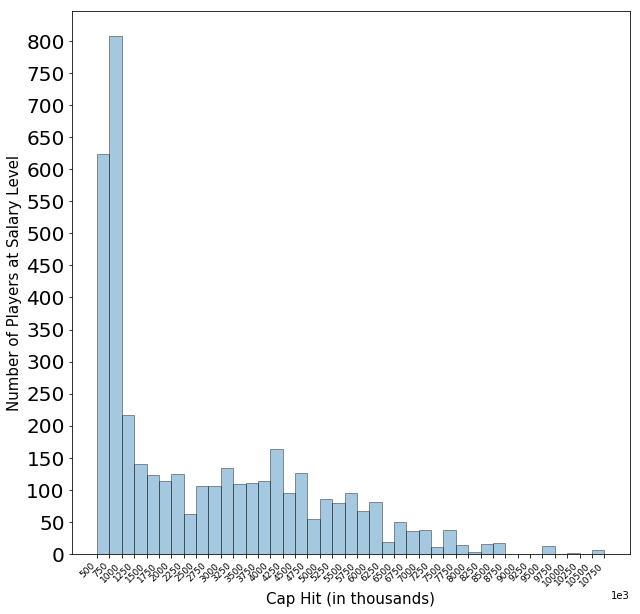

In [282]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.distplot(df['cap_hit'], bins = set_bins, kde=False, axlabel="Cap Hit (in thousands)", hist_kws=dict(edgecolor="k", linewidth=1), ax=ax)
# plt.title('Distribution of Player Cap Hits', fontsize=25)
plt.xticks(ticks=range(500000, 11000000, 250000), rotation=45, fontsize=9, ha='right')
plt.ticklabel_format(style='sci', axis='x', scilimits=(3,3))
plt.yticks(range(0, 850, 50), fontsize=20)
ax.set_xlabel("Cap Hit (in thousands)",fontsize=15)
ax.set_ylabel("Number of Players at Salary Level",fontsize=15)
plt.show()

In [174]:
# Take a look at the variables most correlated with cap_hit
df.corr().loc[:, 'cap_hit'].sort_values(ascending=False)

cap_hit     1.000000
xGF         0.588115
GF          0.580287
CF          0.563647
A           0.559420
TOI%        0.547929
P           0.544977
GS          0.533783
iCF         0.528496
P1          0.506704
TOI         0.499160
xGA         0.454603
GA          0.451025
ixGF        0.432774
G           0.425146
CA          0.423818
P/60        0.387263
GS/60       0.372871
xG+/-       0.371745
C+/-        0.370356
Rel CF%     0.360337
Rel xGF%    0.360023
G+/-        0.346696
CF%         0.342212
P1/60       0.338613
xGF%        0.335001
Rel GF%     0.328721
CF% QoT     0.307650
GF%         0.301047
GP          0.280857
iCF/60      0.271576
ZSR         0.243439
ixGF/60     0.217491
iPENT       0.212628
iPEND       0.205219
PDO         0.159688
iSh%        0.148410
iP+/-      -0.023172
CF% QoC    -0.264072
Name: cap_hit, dtype: float64

# Create Models

In [ ]:
# Notes: Apply Standard Scaler at some point
# Try GridSearchCV
# Apply Pipeline

In [ ]:
df_models = pd.DataFrame()

## Model 1: Highest-correlation in features (r-score > .55)

For my first model, I'm going to simply create a few models (SLR and RF) where the features (independent variables) have an r-score above .55.

In [175]:
# pd.set_option('display.max_row', 100)
df[['xGF', 'GF', 'CF', 'A', 'P', 'TOI%']]

,xGF,GF,CF,A,P,TOI%
0,80.80,87,1760,27,39,35.68
1,81.95,93,1520,20,35,35.80
2,66.53,54,1549,11,21,35.12
3,101.42,115,1935,22,38,38.65
4,37.94,36,746,13,16,27.55
5,9.72,8,303,4,5,13.02
6,25.13,21,583,5,9,25.04
7,13.28,14,312,5,5,25.68
8,12.91,14,291,1,1,22.09
9,4.53,5,152,0,1,15.15


In [176]:
X1 = df[['xGF', 'GF', 'CF', 'A', 'P', 'TOI%']]
y1 = df['cap_hit']

In [177]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,
                                                        y1,
                                                        test_size=.2,
                                                        random_state=42)

lr1 = LinearRegression()

kf1 = KFold(n_splits = 5, shuffle=True, random_state=42)

scores = cross_val_score(lr1, X1_train, y1_train, cv=kf1)
print(scores)
print(scores.mean())

[0.39561726 0.44179173 0.45722054 0.40264518 0.4199964 ]
0.4234542231837091


In [178]:
lr1.fit(X1_train, y1_train)
lr1.score(X1_train, y1_train)

0.4253117997674285

In [179]:
lr1.score(X1_test, y1_test)

0.43392851955437783

In [358]:
y1_preds = lr1.predict(X1_test)

In [364]:
print(np.sqrt(mean_squared_error(y1_test, y1_preds)))

1551372.430250491


Not really the greatest score, but I didn't expect it to be that easy! Going to give these features another go using RandomForestRegressor and GridSearchCV.

Going to give these features another go using RandomForestRegressor.

In [181]:
# Instantiate
rf1 = RandomForestRegressor()

In [183]:
# I tried to be a badass and use something new I learned, 
# but this took forever to run and I simply didn't have the time to let it finish
# Going to skip right to GridSearch
# # Use RandomizedSearchCV to try to get a sense 
# # of the best ranges of parameters to feed into GridSearch
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# random_parameters = {'n_estimators': n_estimators, 
#                      'max_features': max_features, 
#                      'max_depth': max_depth, 
#                      'min_samples_split': min_samples_split,
#                      'min_samples_leaf': min_samples_leaf, 
#                      'bootstrap': bootstrap}

# rf1_ran = RandomizedSearchCV(estimator=rf1, 
#                             param_distributions=random_parameters,
#                             n_iter=200,
#                             cv=5,
#                             random_state=42,
#                             n_jobs=-1)

# rf1_ran.fit(X1, y1)

In [188]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Instantiate
GS1 = GridSearchCV(estimator = rf1,
                           param_grid = params,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

In [195]:
# Fit
GS1.fit(X1_train, y1_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_d

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.2s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, m

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, 

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_s

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.7s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, m

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_sa

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, mi

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_featu

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_feat

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_featur

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3,

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_featu

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_feature

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fea

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.0min


[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.4s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.2s
[CV]  bootstrap=True, max_dep

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  3.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [196]:
GS1.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [198]:
best_est = GS1.best_estimator_
best_est

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [201]:
GS1.best_score_

0.447463223036263

In [206]:
# Just copy and pasting from above
rf1_gs = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [207]:
rf1_gs.fit(X1_train, y1_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [214]:
rf1_gs.score(X1_test, y1_test)

0.4506184437556441

These features clearly aren't enough. Let's try more variables. Next step after that will be standard scaling and/or Lasso.

## Model 2: Everything

For my second model, I'm going to use all the features I have, to see if that adds any predictive value.

In [220]:
X2 = df.drop(axis=1, columns=['Player', 'Season', 'Team', 'Position','cap_hit'])
y2 = df['cap_hit']

In [308]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                        y2,
                                                        test_size=.2,
                                                        random_state=42)

lr2 = LinearRegression(fit_intercept=True)

kf2 = KFold(n_splits = 5, shuffle=True, random_state=42)

scores = cross_val_score(lr2, X2_train, y2_train, cv=kf2)
print(scores)
print(scores.mean())

[0.42315116 0.47946384 0.48462904 0.42862296 0.46273087]
0.4557195737297571


In [309]:
lr2.fit(X2_train, y2_train)
lr2.score(X2_train, y2_train)

0.4677559076090967

In [310]:
lr2.score(X2_test, y2_test)

0.46737056229432883

Slightly better, but barely. Let's see if GridSearch + Random Forest can save us from this mediocrity. 

In [224]:
# Instantiate
rf2 = RandomForestRegressor()

In [225]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Instantiate
GS2 = GridSearchCV(estimator = rf2,
                           param_grid = params,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

In [226]:
# Fit
GS2.fit(X2_train, y2_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_d

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.3s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, m

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, 

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_s

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.4s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_sa

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=90, max_features=2, mi

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_featu

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_feat

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_feat

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_featur

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3,

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   1.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   2.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   2.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_featu

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_feature

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fea

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.3min


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   1.1s
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.5s
[CV]  bootstrap=True, max_dep

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [227]:
GS2.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [228]:
best_est = GS2.best_estimator_
best_est

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [229]:
GS2.best_score_

0.4524910072558504

In [230]:
# Just copy and pasting from above
rf2_gs = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [231]:
rf2_gs.fit(X1_train, y1_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [367]:
rf2_gs.score(X1_train, y2_train)

0.7756245446589005

In [368]:
rf2_gs.score(X1_test, y1_test)

0.45495103106520884

In [365]:
y2_preds = lr2.predict(X2_test)

In [366]:
print(np.sqrt(mean_squared_error(y2_test, y2_preds)))

1504849.3137329824


In [370]:
rf2_gs_preds = rf2_gs.predict(X2_test)

ValueError: Number of features of the model must match the input. Model n_features is 6 and input n_features is 38 

In [371]:
print(np.sqrt(mean_squared_error(y2_test, rf2_gs_preds)))

NameError: name 'rf2_gs_preds' is not defined

It's not really much better. Let's see if doing the same process, but scaling our variables works.

## Model 3: StandardScalar + LassoCV

In [234]:
# Using all features again
X3 = df.drop(axis=1, columns=['Player', 'Season', 'Team', 'Position','cap_hit'])
y3 = df['cap_hit']

In [235]:
# Instantiate Scaler
ss3 = StandardScaler()

In [236]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,
                                                        y3,
                                                        test_size=.2,
                                                        random_state=42)

In [237]:
X3_train_scaled = ss3.fit_transform(X3_train)
X3_test_scaled = ss3.transform(X3_test)

In [247]:
# # Can't get this to work, so skipping it
# params = {
#     'n_alphas': [100, 150, 200, 250],
#     'alphas': [.0001, .001, .01, .1, .5, 1, 5],
#     'max_iter': [250, 500, 1000],
#     'cv': [3, 5, 10]
#         } 

# GS3 = GridSearchCV(estimator = LassoCV(),
#                            param_grid = params,
#                            cv = 3,
#                            n_jobs = -1,
#                            verbose = 2)

# # Fit
# GS3.fit(X3_train_scaled, y3_train)

In [249]:
lasso3 = LassoCV(n_alphas = 500, cv = 10)

In [250]:
lasso3_scores = cross_val_score(lasso3, X3_train_scaled, y3_train)
print(lasso3_scores)
print(lasso3_scores.mean())

[0.44149403 0.4549043  0.46311146]
0.4531699322322142


In [251]:
lasso3.fit(X3_train_scaled, y3_train)
lasso3.score(X3_test_scaled, y3_test)

0.4721485514611437

In [372]:
y3_preds = lasso3.predict(X3_test)

In [373]:
print(np.sqrt(mean_squared_error(y3_test, y3_preds)))

63921071.07970959


In [ ]:
lasso3.

I'm starting to think that I may not be able to create good models based off of this data.

## Model 4: StandardScalar + ElasticNetCV

In [252]:
# Using all features again
X4 = df.drop(axis=1, columns=['Player', 'Season', 'Team', 'Position','cap_hit'])
y4 = df['cap_hit']

In [253]:
# Instantiate Scaler
ss4 = StandardScaler()

In [254]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,
                                                        y4,
                                                        test_size=.2,
                                                        random_state=42)

In [255]:
X4_train_scaled = ss4.fit_transform(X4_train)
X4_test_scaled = ss4.transform(X4_test)

In [257]:
l1_ratios = np.linspace(0.1, 1.0, num=25)
enet4 = ElasticNetCV(l1_ratio=l1_ratios, cv=10, n_alphas=250, max_iter=2500)

enet4_scores = cross_val_score(enet4, X4_train_scaled, y4_train, cv=10)
print(enet4_scores.mean())

0.45086930621743165


In [374]:
enet4_scores = cross_val_score(enet4, X4_test_scaled, y4_test, cv=10)
print(enet4_scores.mean())

0.4453077661448555


All of my models seem to come in at around the same score. I don't think it's possible to meaningfully predict salaries based on these poor scores.

## Model 5: Polynomial Features + StandardScalar + LassoCV

In [260]:
# Using all features again
X5 = df.drop(axis=1, columns=['Player', 'Season', 'Team', 'Position','cap_hit'])
y5 = df['cap_hit']

In [261]:
poly5 = PolynomialFeatures(include_bias=False)

In [262]:
X5_poly = poly5.fit_transform(X5)

In [263]:
X5_train_poly, X5_test_poly, y5_train_poly, y5_test_poly = train_test_split(X5_poly, y5, test_size=.2, random_state=42)

In [264]:
# Instantiate Scaler
ss5 = StandardScaler()
X5_train_poly_scaled = ss5.fit_transform(X5_train_poly)
X5_test_poly_scaled = ss5.transform(X5_test_poly)

In [266]:
lasso_poly5 = LassoCV(verbose=1, max_iter=500)

lp5_scores = cross_val_score(lasso_poly5, X5_train_poly_scaled, y5_train_poly)
print(lp5_scores)
print(lp5_scores.mean())

......................................................................../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceW

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

.[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
...................................................................../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-p

.........................................................................../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: Convergenc

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

[0.50027451 0.4926285  0.51313953]
0.5020141791735048


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [379]:
model5 = lasso_poly5.fit(X5_train_poly, y5_train_poly)

...................................................................................................................................................................................................../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems

In [375]:
lp5_scores = cross_val_score(lasso_poly5, X5_test_poly_scaled, y5_test_poly)
print(lp5_scores)
print(lp5_scores.mean())

................................................................/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

.............................................................../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.../anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

[0.47954843 0.41732413 0.44708178]
0.44798478179587436


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
./anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s finished


In [ ]:
# Scores got lost in all the soft warnings:
# [0.50027451 0.4926285  0.51313953]
# 0.5020141791735048

In [377]:
y5_preds = lasso_poly5.predict(X5_train_poly)

NotFittedError: This LassoCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [378]:
print(np.sqrt(mean_squared_error(y5_test_poly, y5_preds)))

NameError: name 'y5_preds' is not defined

Welp, looks like I wasn't able to save hockey like Brad Pitt saved baseball.

## Interpreting my Models 

Because I really don't know what I'm doing, I'm going to use my lr2 model.

In [311]:
preds = lr2.predict(df.drop(axis=1, columns=['Player', 'Season', 'Team', 'Position','cap_hit']))

ValueError: shapes (4003,39) and (38,) not aligned: 39 (dim 1) != 38 (dim 0)

In [288]:
df.shape

(4003, 43)

In [289]:
preds.shape

(4003,)

In [291]:
y1.shape

(4003,)

In [293]:
df['cap_hit'].values

array([1775000,  925000,  925000, ..., 1600000,  700000,  925000])

In [303]:
df['predicted_cap_hit'] = [pd.Series(preds) - pd.Series(df['cap_hit'].values)]

ValueError: Length of values does not match length of index

In [312]:
df['predicted_cap_hit'] = preds

In [344]:
df['preds-actual'] = preds - df['cap_hit'].values

In [345]:
df['actual-preds'] = df['cap_hit'].values - preds

In [317]:
df['preds_actual'].sort_values().head(10)

1942   -6.403421e+06
396    -5.597727e+06
3403   -5.501275e+06
1706   -5.488481e+06
323    -5.273529e+06
128    -5.221957e+06
1943   -5.166968e+06
1034   -5.156936e+06
150    -4.971319e+06
1944   -4.844826e+06
Name: preds_actual, dtype: float64

In [318]:
df['actual_preds'].sort_values().head(10)

1356   -6.191788e+06
909    -5.663629e+06
908    -4.931784e+06
138    -4.683279e+06
2268   -4.606852e+06
1905   -4.587498e+06
1937   -4.396056e+06
1432   -4.167917e+06
333    -4.087091e+06
2785   -4.067525e+06
Name: actual_preds, dtype: float64

In [327]:
list(df['preds_actual'].sort_values().head(10).index)

[1942, 396, 3403, 1706, 323, 128, 1943, 1034, 150, 1944]

In [319]:
list(df['actual_preds'].sort_values().head(10).index)

Int64Index([1356, 909, 908, 138, 2268, 1905, 1937, 1432, 333, 2785], dtype='int64')

In [351]:
# Most undervalued players:
# df_under = df.iloc[df['actual_preds'].sort_values().head(10).index]
df.iloc[df['actual_preds'].sort_values().head(10).index]

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,ZSR,TOI%,CF% QoT,CF% QoC,cap_hit,predicted_cap_hit,preds_actual,actual_preds,preds-actual,actual-preds
1356,Erik Karlsson,2011-2012,OTT,D,81,2050.66,19,58,77,55,...,64.94,41.64,54.46,45.68,875000,7.066788e+06,6.191788e+06,-6.191788e+06,6.191788e+06,-6.191788e+06
909,Connor Mcdavid,2017-2018,EDM,C,82,1765.89,41,66,107,79,...,61.02,35.51,52.53,47.40,925000,6.588629e+06,5.663629e+06,-5.663629e+06,5.663629e+06,-5.663629e+06
908,Connor Mcdavid,2016-2017,EDM,C,82,1732.77,30,70,100,74,...,62.81,34.71,53.10,46.89,925000,5.856784e+06,4.931784e+06,-4.931784e+06,4.931784e+06,-4.931784e+06
138,Alex Pietrangelo,2011-2012,STL,D,81,2001.81,12,37,49,32,...,48.87,40.59,51.81,51.36,816666,5.499945e+06,4.683279e+06,-4.683279e+06,4.683279e+06,-4.683279e+06
2268,Leon Draisaitl,2016-2017,EDM,C,82,1548.48,29,48,77,60,...,61.23,31.06,55.67,45.96,925000,5.531852e+06,4.606852e+06,-4.606852e+06,4.606852e+06,-4.606852e+06
1905,John Tavares,2011-2012,NYI,C,82,1686.61,31,50,81,67,...,67.52,33.82,48.07,45.25,900000,5.487498e+06,4.587498e+06,-4.587498e+06,4.587498e+06,-4.587498e+06
1937,Jonathan Marchessault,2017-2018,VGK,C,77,1347.85,27,47,74,60,...,61.75,28.92,54.42,45.73,750000,5.146056e+06,4.396056e+06,-4.396056e+06,4.396056e+06,-4.396056e+06
1432,Gabriel Landeskog,2013-2014,COL,L,81,1512.34,26,39,65,54,...,53.25,30.72,50.93,46.68,925000,5.092917e+06,4.167917e+06,-4.167917e+06,4.167917e+06,-4.167917e+06
333,Artemi Panarin,2015-2016,CHI,C,80,1480.87,30,47,77,59,...,81.40,30.63,55.79,44.70,812500,4.899591e+06,4.087091e+06,-4.087091e+06,4.087091e+06,-4.087091e+06
2785,Mikko Rantanen,2017-2018,COL,R,81,1535.76,29,55,84,58,...,66.95,31.31,52.65,44.03,894167,4.961692e+06,4.067525e+06,-4.067525e+06,4.067525e+06,-4.067525e+06


In [352]:
# Most overvalued players:
# df_over = df.iloc[df['preds_actual'].sort_values().head(10).index]
df.iloc[df['preds_actual'].sort_values().head(10).index]

,Player,Season,Team,Position,GP,TOI,G,A,P,P1,...,ZSR,TOI%,CF% QoT,CF% QoC,cap_hit,predicted_cap_hit,preds_actual,actual_preds,preds-actual,actual-preds
1942,Jonathan Toews,2015-2016,CHI,C,80,1538.72,27,29,56,44,...,58.34,31.76,55.15,48.89,10500000,4.096579e+06,-6.403421e+06,6.403421e+06,-6.403421e+06,6.403421e+06
396,Bobby Ryan,2016-2017,OTT,R,62,963.34,13,12,25,21,...,59.10,25.77,55.20,45.08,7250000,1.652273e+06,-5.597727e+06,5.597727e+06,-5.597727e+06,5.597727e+06
3403,Scott Gomez,2011-2012,MTL,C,38,537.09,2,9,11,10,...,69.57,23.40,53.28,44.56,7357143,1.855868e+06,-5.501275e+06,5.501275e+06,-5.501275e+06,5.501275e+06
1706,Jason Spezza,2017-2018,DAL,C,78,1014.48,8,18,26,21,...,62.85,21.83,55.86,44.45,7500000,2.011519e+06,-5.488481e+06,5.488481e+06,-5.488481e+06,5.488481e+06
323,Anze Kopitar,2016-2017,L.A,C,76,1578.27,12,39,51,34,...,53.61,34.25,56.87,48.69,10000000,4.726471e+06,-5.273529e+06,5.273529e+06,-5.273529e+06,5.273529e+06
128,Alex Ovechkin,2011-2012,WSH,L,78,1543.41,38,27,65,52,...,65.34,32.66,54.24,43.75,9538462,4.316505e+06,-5.221957e+06,5.221957e+06,-5.221957e+06,5.221957e+06
1943,Jonathan Toews,2016-2017,CHI,C,72,1451.09,21,37,58,42,...,55.43,33.22,53.01,48.53,10500000,5.333032e+06,-5.166968e+06,5.166968e+06,-5.166968e+06,5.166968e+06
1034,Dany Heatley,2013-2014,MIN,L,76,1126.21,12,16,28,24,...,63.26,24.45,56.45,44.45,7500000,2.343064e+06,-5.156936e+06,5.156936e+06,-5.156936e+06,5.156936e+06
150,Alex Semin,2014-2015,CAR,R,57,907.66,6,13,19,13,...,64.71,26.35,56.00,46.08,7000000,2.028681e+06,-4.971319e+06,4.971319e+06,-4.971319e+06,4.971319e+06
1944,Jonathan Toews,2017-2018,CHI,C,74,1457.10,20,31,51,41,...,57.20,32.58,54.64,48.07,10500000,5.655174e+06,-4.844826e+06,4.844826e+06,-4.844826e+06,4.844826e+06


In [356]:
df_under[['Player', 'Season', 'predicted_cap_hit', 'cap_hit', 'preds-actual']]

,Player,Season,predicted_cap_hit,cap_hit,preds-actual
1356,Erik Karlsson,2011-2012,7.066788e+06,875000,6.191788e+06
909,Connor Mcdavid,2017-2018,6.588629e+06,925000,5.663629e+06
908,Connor Mcdavid,2016-2017,5.856784e+06,925000,4.931784e+06
138,Alex Pietrangelo,2011-2012,5.499945e+06,816666,4.683279e+06
2268,Leon Draisaitl,2016-2017,5.531852e+06,925000,4.606852e+06
1905,John Tavares,2011-2012,5.487498e+06,900000,4.587498e+06
1937,Jonathan Marchessault,2017-2018,5.146056e+06,750000,4.396056e+06
1432,Gabriel Landeskog,2013-2014,5.092917e+06,925000,4.167917e+06
333,Artemi Panarin,2015-2016,4.899591e+06,812500,4.087091e+06
2785,Mikko Rantanen,2017-2018,4.961692e+06,894167,4.067525e+06


In [357]:
df_over[['Player', 'Season', 'cap_hit', 'predicted_cap_hit','actual-preds']]

,Player,Season,cap_hit,predicted_cap_hit,actual-preds
1942,Jonathan Toews,2015-2016,10500000,4.096579e+06,6.403421e+06
396,Bobby Ryan,2016-2017,7250000,1.652273e+06,5.597727e+06
3403,Scott Gomez,2011-2012,7357143,1.855868e+06,5.501275e+06
1706,Jason Spezza,2017-2018,7500000,2.011519e+06,5.488481e+06
323,Anze Kopitar,2016-2017,10000000,4.726471e+06,5.273529e+06
128,Alex Ovechkin,2011-2012,9538462,4.316505e+06,5.221957e+06
1943,Jonathan Toews,2016-2017,10500000,5.333032e+06,5.166968e+06
1034,Dany Heatley,2013-2014,7500000,2.343064e+06,5.156936e+06
150,Alex Semin,2014-2015,7000000,2.028681e+06,4.971319e+06
1944,Jonathan Toews,2017-2018,10500000,5.655174e+06,4.844826e+06


For closing thoughts / next steps:
NHL deputy commissioner Bill Daly confirmed to theScore that a full rollout of player and puck tracking is penciled in to debut during the 2019-20 season.